# Calculate the forward gravity of ice and firn

We'll load some datasets of ice surface, ice thickness and firn thickness, convert them into layers of vertical prisms, assign each prism a density, and calculate the gravity effect of the layers of prisms. 

# Ice Equivalent Thickness

From [Griggs and Bamber 2009](https://doi.org/10.1029/2009GL039527) and [2011](https://doi.org/10.3189/002214311796905659)

"If ice is assumed to be in hydrostatic equilibrium, ice thickness can be calculated as"

$
H_i = {(e - \delta) \rho_w \
    \over \rho_w - \rho_i} = Z - \delta
$

where 
* $H_i$ is the equivalent ice thickness, 
    * i.e., the thickness if all the ice column was at the density of meteoric ice
* $Z$ is the actual ice thickness
    * i.e., including firn
* $e$ is the elevation above mean sea level
    * the freeboard
* $\delta$ is the firn density correction, 
    * i.e., the difference between the actual depth of the firn layer and the depth that the firn would be if it was all at the density of meteoric ice
* $\rho_w$ is the density of water 
    * for RIS use $1024 \pm 5 kg m^{-3}$ 
* $\rho_i$ is the density of meteoric ice
    * use  $917 \pm 5 kg m^{-3}$ 

"Hydrostatic equilibrium can only be considered valid when ice is floating freely, which is typically several ice thicknesses from the grounding line." Griggs and Bamber 2009

"Thus, in general, hydrostatic equilibrium may not be valid up to ~10 km from the grounding line." Griggs and Bamber 2011

"Uncertainty in the firn density correction can therefore dominate the error budget in the ice thickness estimation and it increases, in percentage terms, with decreasing ice thickness." Griggs and Bamber 2011

"The thickness of the firn column in Antarctica, taken as z830, is only 40–50 m around and on the big ice shelves (Ross Ice Shelf...)" Ligtenberg et al. 2011

<img src="../figures/ice_equivalent_thickness.svg" width="400"/>

van den Broeke 2018 | Ligtenberg et al. 2011
:---: | :---:
<img src="../figures/firn_thickness_Broeke_2018.jpg" width="400"/>|<img src="../figures/firn_thickness.jpg" width="600"/>

# Import packages

In [20]:
# %%capture
%load_ext autoreload
%autoreload 2

import harmonica as hm
import verde as vd
import xarray as xr
import numpy as np
import pyvista as pv
import pygmt
from typing import Union
from antarctic_plots import maps, utils, regions, fetch
import sys

sys.path.append("../")
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.plotting as plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Gather datasets

Set region, resolutions, grid node registration, and elevation reference

In [2]:
region = regions.ross_ice_shelf
spacing = 5e3
registration = "g"
reference = "ellipsoid"

Make a mask for the Ross Ice Shelf

Mask info: (5000.0, [-680000.0, 470000.0, -1420000.0, -310000.0], 1.0, 1.0, 'g')


makecpt [ERROR]: Option T: min >= max


grid region can't be extracted.


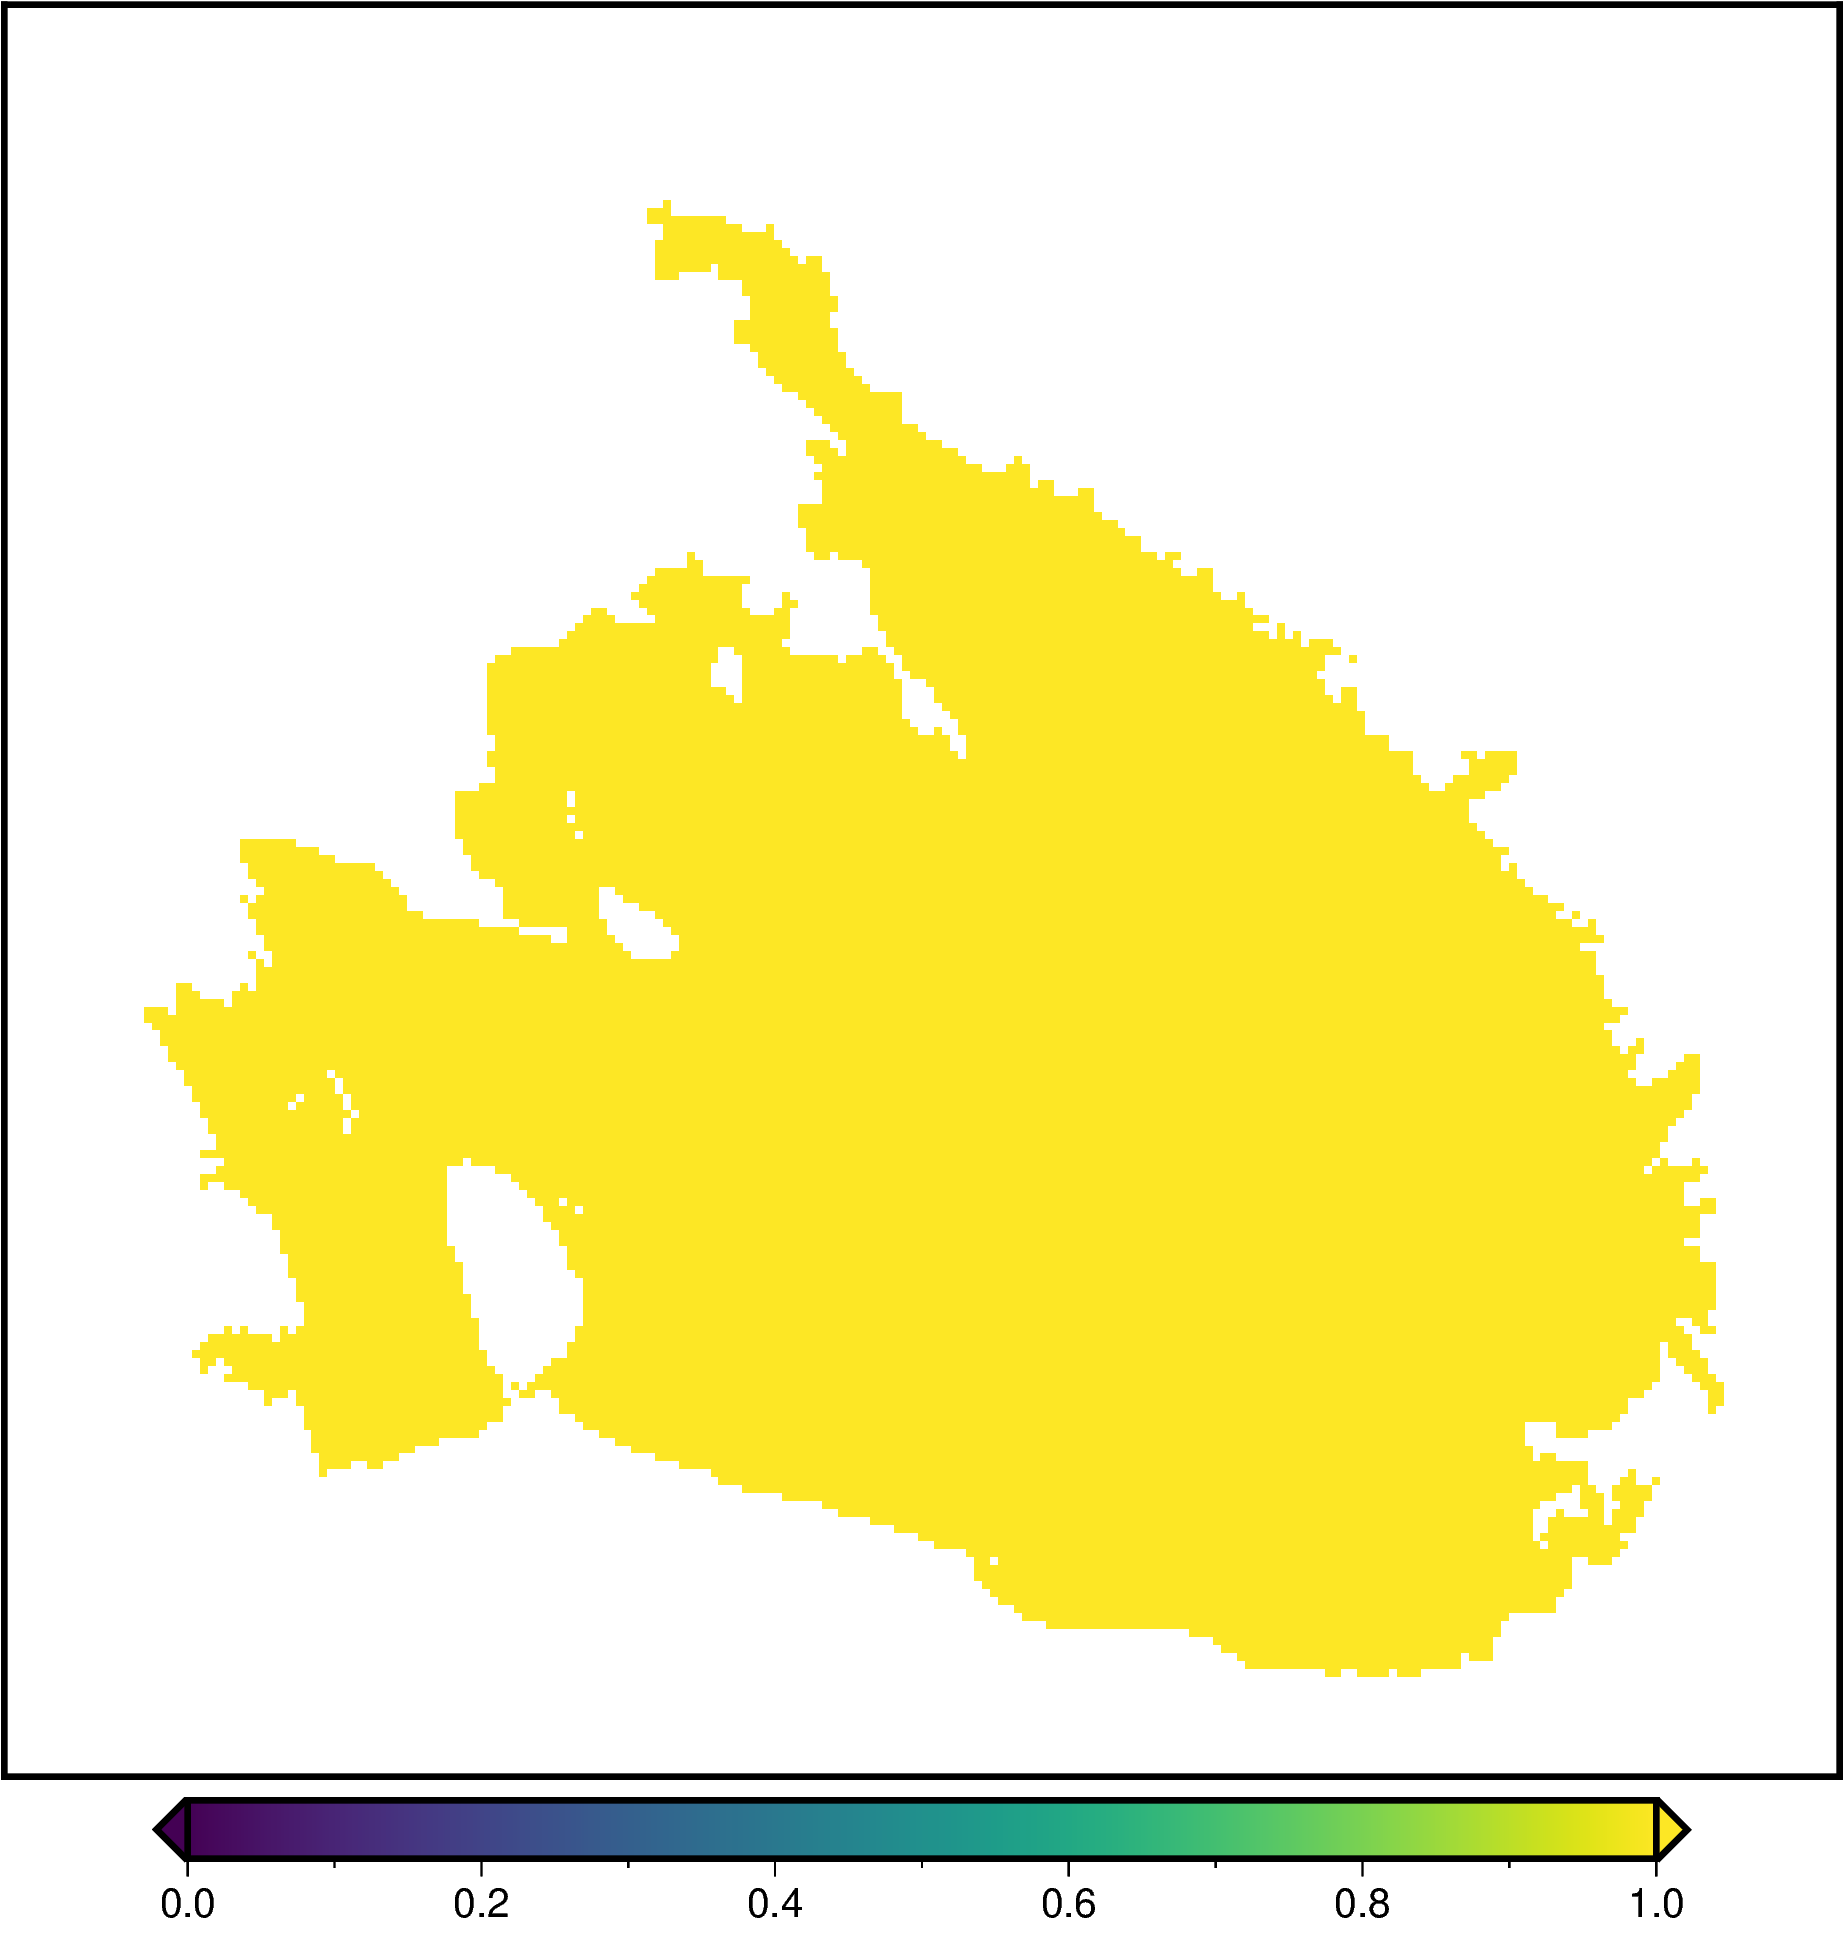

In [3]:
mask = utils.mask_from_shp(
    "../plotting/RIS_outline.shp",
    masked=True,
    invert=False,
    region=region,
    spacing=spacing,
    pixel_register=False,
)
print("Mask info:", utils.get_grid_info(mask))

fig = maps.plot_grd(mask)
fig.show()

## REMA
* 1km resolution (finer versions available)
* referenced to WGS-84 ellipsoid

In [8]:
%%capture
REMA = fetch.REMA(
    version=1e3,
    region=region,
    spacing=spacing,
    registration=registration,
)

# REMA = REMA * mask

## Bedmap2

"The majority of direct ice thickness measurements from radar and seismic techniques were calculated **with the inclusion of a “firn correction”.** ... The ice thickness measurements compiled for Bedmap2, thus, represent the researchers’ best estimate of the **physical ice thickness**, rather than an **“ice-equivalent” thickness"**


"ice shelf thickness derived from satellite altimetry measurements of freeboard (Griggs and Bamber, 2011)"

<img src="../figures/bedmap2_surface_coverage.JPG" width="600"/>

For the Ross Ice Shelf:
* surface elevation from satellite altimetry (Griggs and Bamber, 2011)
* ice thickness from satellite altimetry measurements of freeboard (Griggs and Bamber, 2011)

This means the supplied surface is the true snow surface, and the ice base is the true bottom of the ice. 

$
Z_{top} = Z_{surface}
$

$
Z_{bottom} = Z_{surface} - t_{ice}
$

In [9]:
# get surface
bedmap2_surface = fetch.bedmap2(
    layer="surface",
    region=region,
    spacing=spacing,
    registration=registration,
    reference=reference,
    verbose="e",
)  # .rename('surface')

# get thickness
bedmap2_thickness = fetch.bedmap2(
    layer="thickness",
    region=region,
    spacing=spacing,
    registration=registration,
    verbose="e",
)  # .rename('thickness')

# merge dataarrays into a dataset
# doesn't work with pygmt
# bedmap2 = xr.merge([bedmap2_surface, bedmap2_thickness])

# mask to within RIS grounding line
# bedmap2_surface = bedmap2_surface * mask
# bedmap2_thickness = bedmap2_thickness * mask

bedmap2_icebase = bedmap2_surface - bedmap2_thickness

print("Bedmap2 surface info:", utils.get_grid_info(bedmap2_surface))
print("Bedmap2 thickness info:", utils.get_grid_info(bedmap2_thickness))
print("Bedmap2 icebase info:", utils.get_grid_info(bedmap2_icebase))

Extracting 'bedmap2_tiff/bedmap2_surface.tif' from '/Users/home/tankerma/.cache/pooch/antarctic_plots/topography/bedmap2_tiff.zip' to '/Users/home/tankerma/.cache/pooch/antarctic_plots/topography/bedmap2_surface'


converting to be referenced to the WGS84 ellipsoid


Extracting 'bedmap2_tiff/gl04c_geiod_to_WGS84.tif' from '/Users/home/tankerma/.cache/pooch/antarctic_plots/topography/bedmap2_tiff.zip' to '/Users/home/tankerma/.cache/pooch/antarctic_plots/topography/bedmap2_gl04c_geiod_to_WGS84'


spacing larger than original, filtering and resampling


Extracting 'bedmap2_tiff/bedmap2_thickness.tif' from '/Users/home/tankerma/.cache/pooch/antarctic_plots/topography/bedmap2_tiff.zip' to '/Users/home/tankerma/.cache/pooch/antarctic_plots/topography/bedmap2_thickness'


spacing larger than original, filtering and resampling
Bedmap2 surface info: (5000.0, [-680000.0, 470000.0, -1420000.0, -310000.0], -50.47265625, 3695.00488281, 'g')
Bedmap2 thickness info: (5000.0, [-680000.0, 470000.0, -1420000.0, -310000.0], 0.0, 3501.38232422, 'g')
Bedmap2 icebase info: (5000.0, [-680000.0, 470000.0, -1420000.0, -310000.0], -2567.60693359, 3574.09716797, 'g')


compare surface to REMA, should be similar since Bedmap surface is true snow surface (not ice equivalent surface)

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


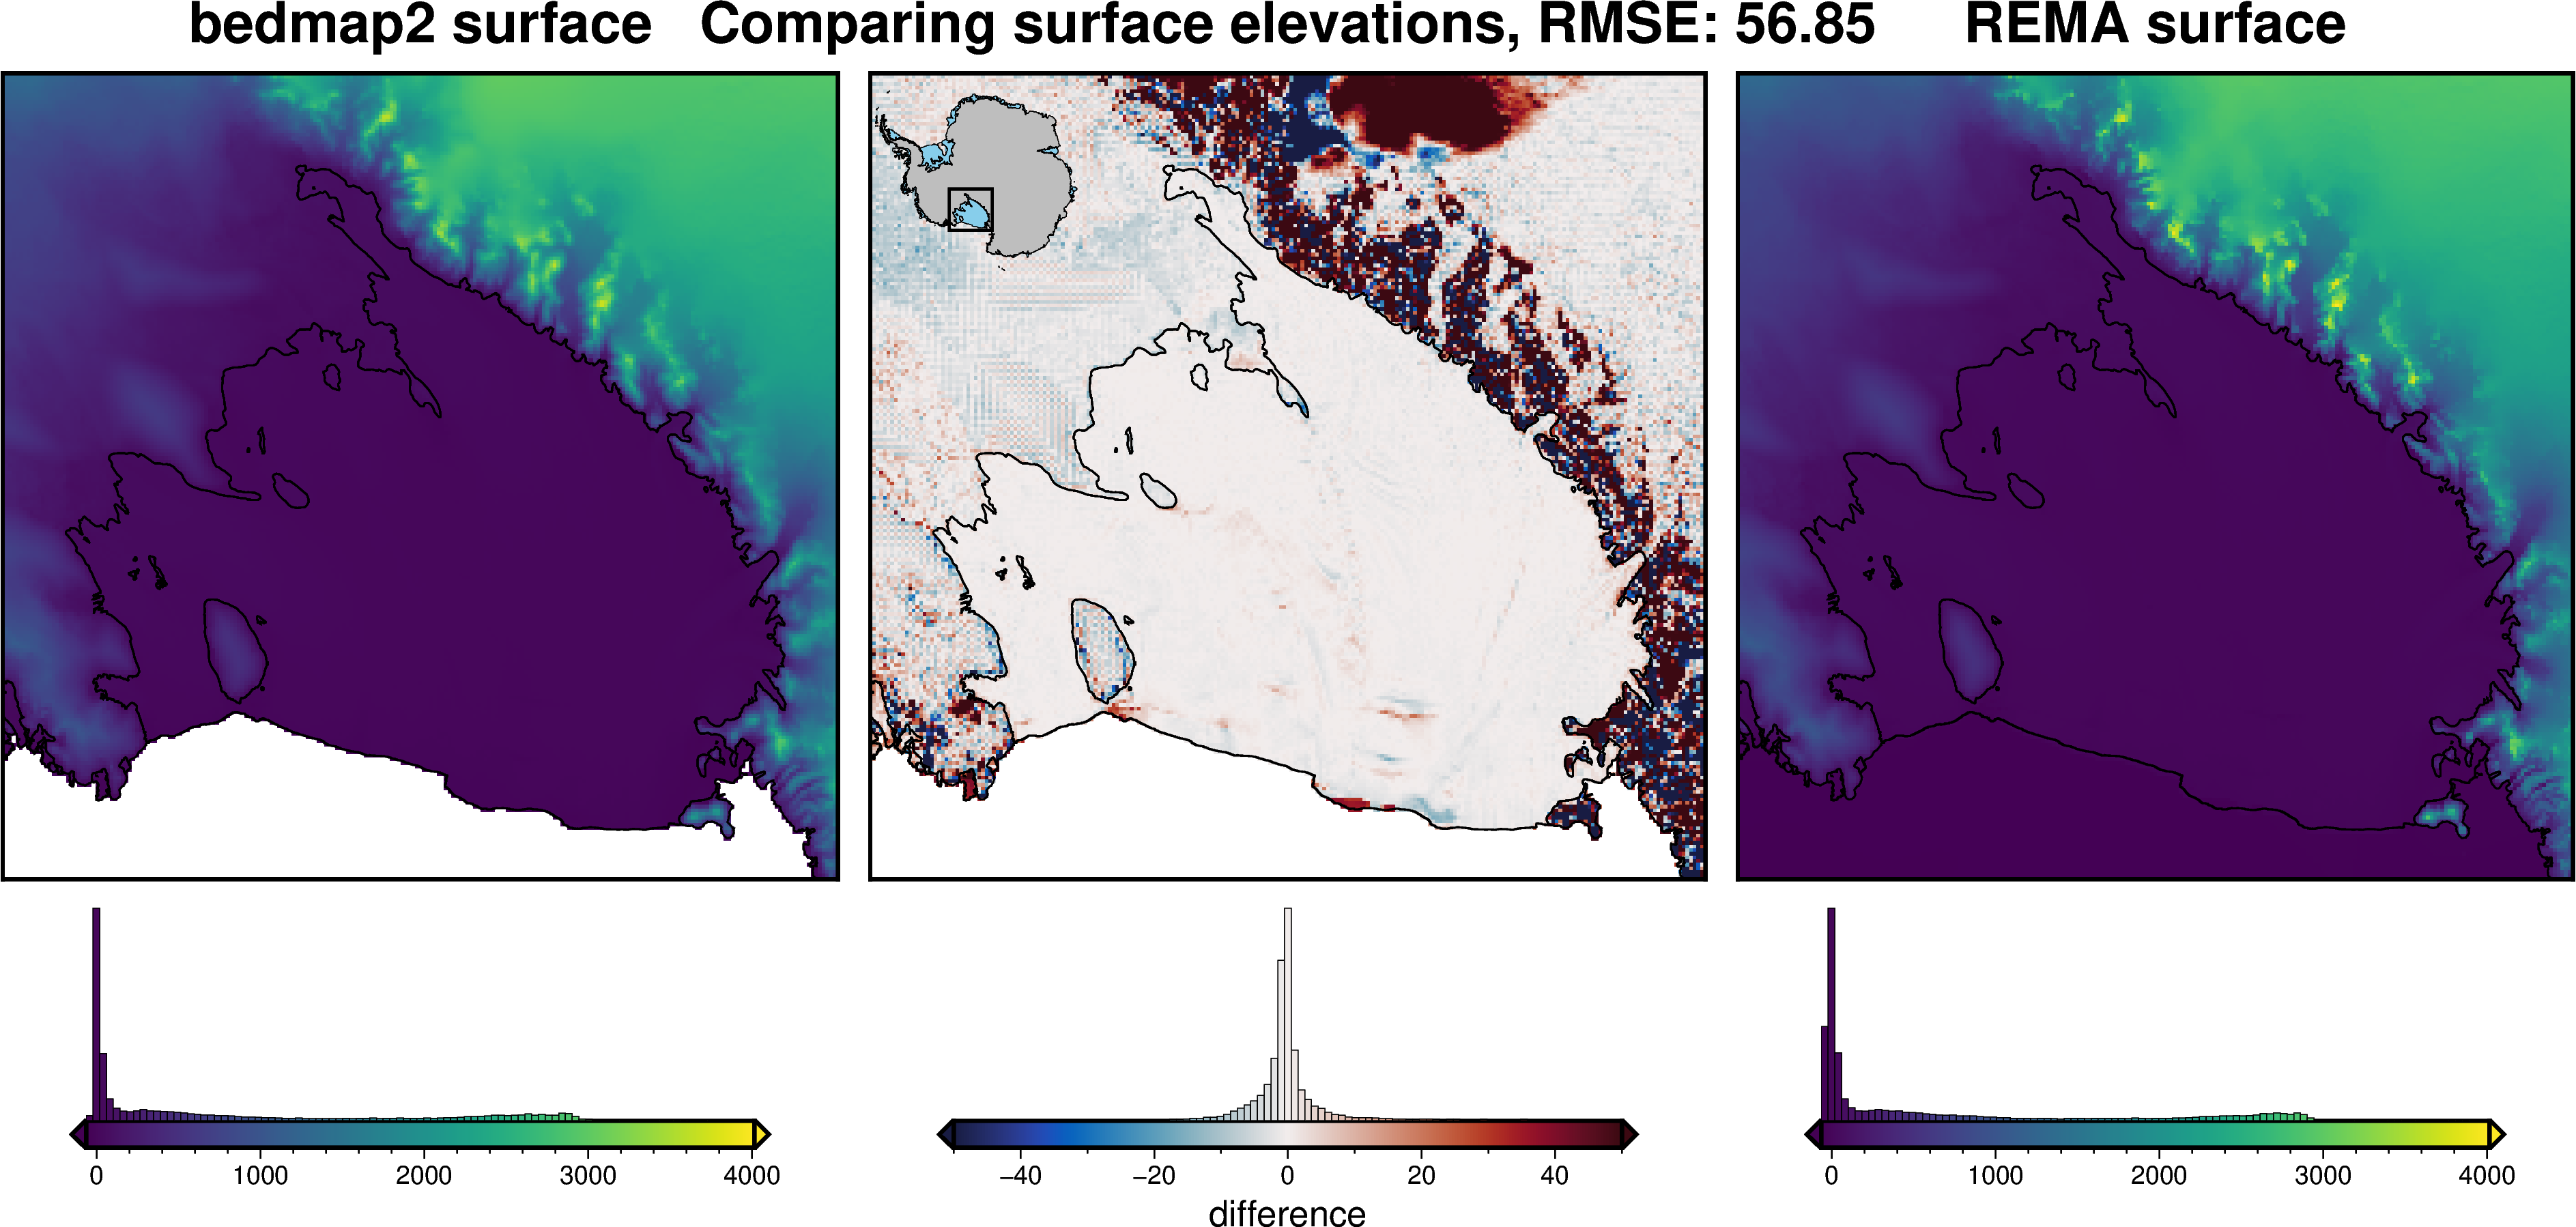

In [11]:
grids = utils.grd_compare(
    bedmap2_surface,
    REMA,
    plot=True,
    grid1_name="bedmap2 surface",
    grid2_name="REMA surface",
    title="Comparing surface elevations",
    diff_maxabs=50,
    hist=True,
)

## Bedmachine

"The surface elevation and ice thickness are in **ice equivalent** as they include a firn air content correction. The elevation of the top of the snow, which is provided by REMA [Howat et al., 2019], can be calculated by **adding the firn depth correction** provided in the netCDF"

"we derive the ice thickness of floating ice shelves by relying on the hydrostatic equilibrium"

**Ice equivalent**
___
$
Z_{top} = Z_{surface}
$

$
Z_{bottom} = Z_{surface} - t_{ice}
$


**True geometry**
___ 
* $
Z_{top} = Z_{surface} + t_{firn}
$

"The ice shelf thickness, $t_{shelf}$, is therefore the sum of an ice equivalent ice thickness, $t_{ice}$, and firn depth correction, $t_{firn}$."

* $
t_{shelf} = t_{ice} + t_{firn}
$

Therefore,

* $
Z_{bottom} = Z_{top} - t_{shelf}
$

Substituting in $Z_{top}$ and $t_{shelf}$,

* $
Z_{bottom} = (Z_{surface} + t_{firn}) - (t_{ice} + t_{firn})
$

Simplifying

* $
Z_{bottom} = Z_{surface} - t_{ice}
$


___
This means, $Z_{bottom}$ is the same for both **ice equivalent** and **true geometry** scenarios.

While $Z_{top}$ for **ice equivalent** is Z_{surface}, and $Z_{top}$ for **true geometry** is Z_{surface} + t_{firn}


In [12]:
# get surface ice equivalent data
bedmachine_surface_ice_eq = fetch.bedmachine(
    layer="surface",
    region=region,
    spacing=spacing,
    registration=registration,
    reference=reference,
    verbose="e",
)

# get ice equivalent thickness data
bedmachine_thickness_ice_eq = fetch.bedmachine(
    layer="thickness",
    region=region,
    spacing=spacing,
    registration=registration,
    verbose="e",
)

# get firn data
bedmachine_firn = fetch.bedmachine(
    layer="firn",
    region=region,
    spacing=spacing,
    registration=registration,
    verbose="e",
)

# remove cells with ice thickness = 0
bedmachine_thickness_ice_eq = bedmachine_thickness_ice_eq.where(
    bedmachine_thickness_ice_eq != 0
)
bedmachine_surface_ice_eq = bedmachine_surface_ice_eq.where(
    bedmachine_thickness_ice_eq.notnull()
)

# mask the datasets to the RIS
# bedmachine_surface_ice_eq = bedmachine_surface_ice_eq * mask
# bedmachine_thickness_ice_eq = bedmachine_thickness_ice_eq * mask
# bedmachine_firn = bedmachine_firn * mask

# calculate ice base
bedmachine_icebase = bedmachine_surface_ice_eq - bedmachine_thickness_ice_eq

# calculate true surface
# surface + firn corr
bedmachine_surface_true = bedmachine_surface_ice_eq + bedmachine_firn

print(
    "bedmachine ice equivalent surface info:",
    utils.get_grid_info(bedmachine_surface_ice_eq),
)
print(
    "bedmachine ice equivalent thickness info:",
    utils.get_grid_info(bedmachine_thickness_ice_eq),
)
print("bedmachine firn info:", utils.get_grid_info(bedmachine_firn))

converting to be reference to the WGS84 ellipsoid
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
spacing larger than original, filtering and resampling
bedmachine ice equivalent surface info: (5000.0, [-680000.0, 470000.0, -1420000.0, -310000.0], -57.0, 4220.42285156, 'g')
bedmachine ice equivalent thickness info: (5000.0, [-680000.0, 470000.0, -1420000.0, -310000.0], 0.00032609506161, 3618.57592773, 'g')
bedmachine firn info: (5000.0, [-680000.0, 470000.0, -1420000.0, -310000.0], 0.0, 35.8249588013, 'g')


compare REMA to true bedmachine surface (firn included), should be similar

returning original grid
returning original grid
returning original grid
returning original grid
returning original grid


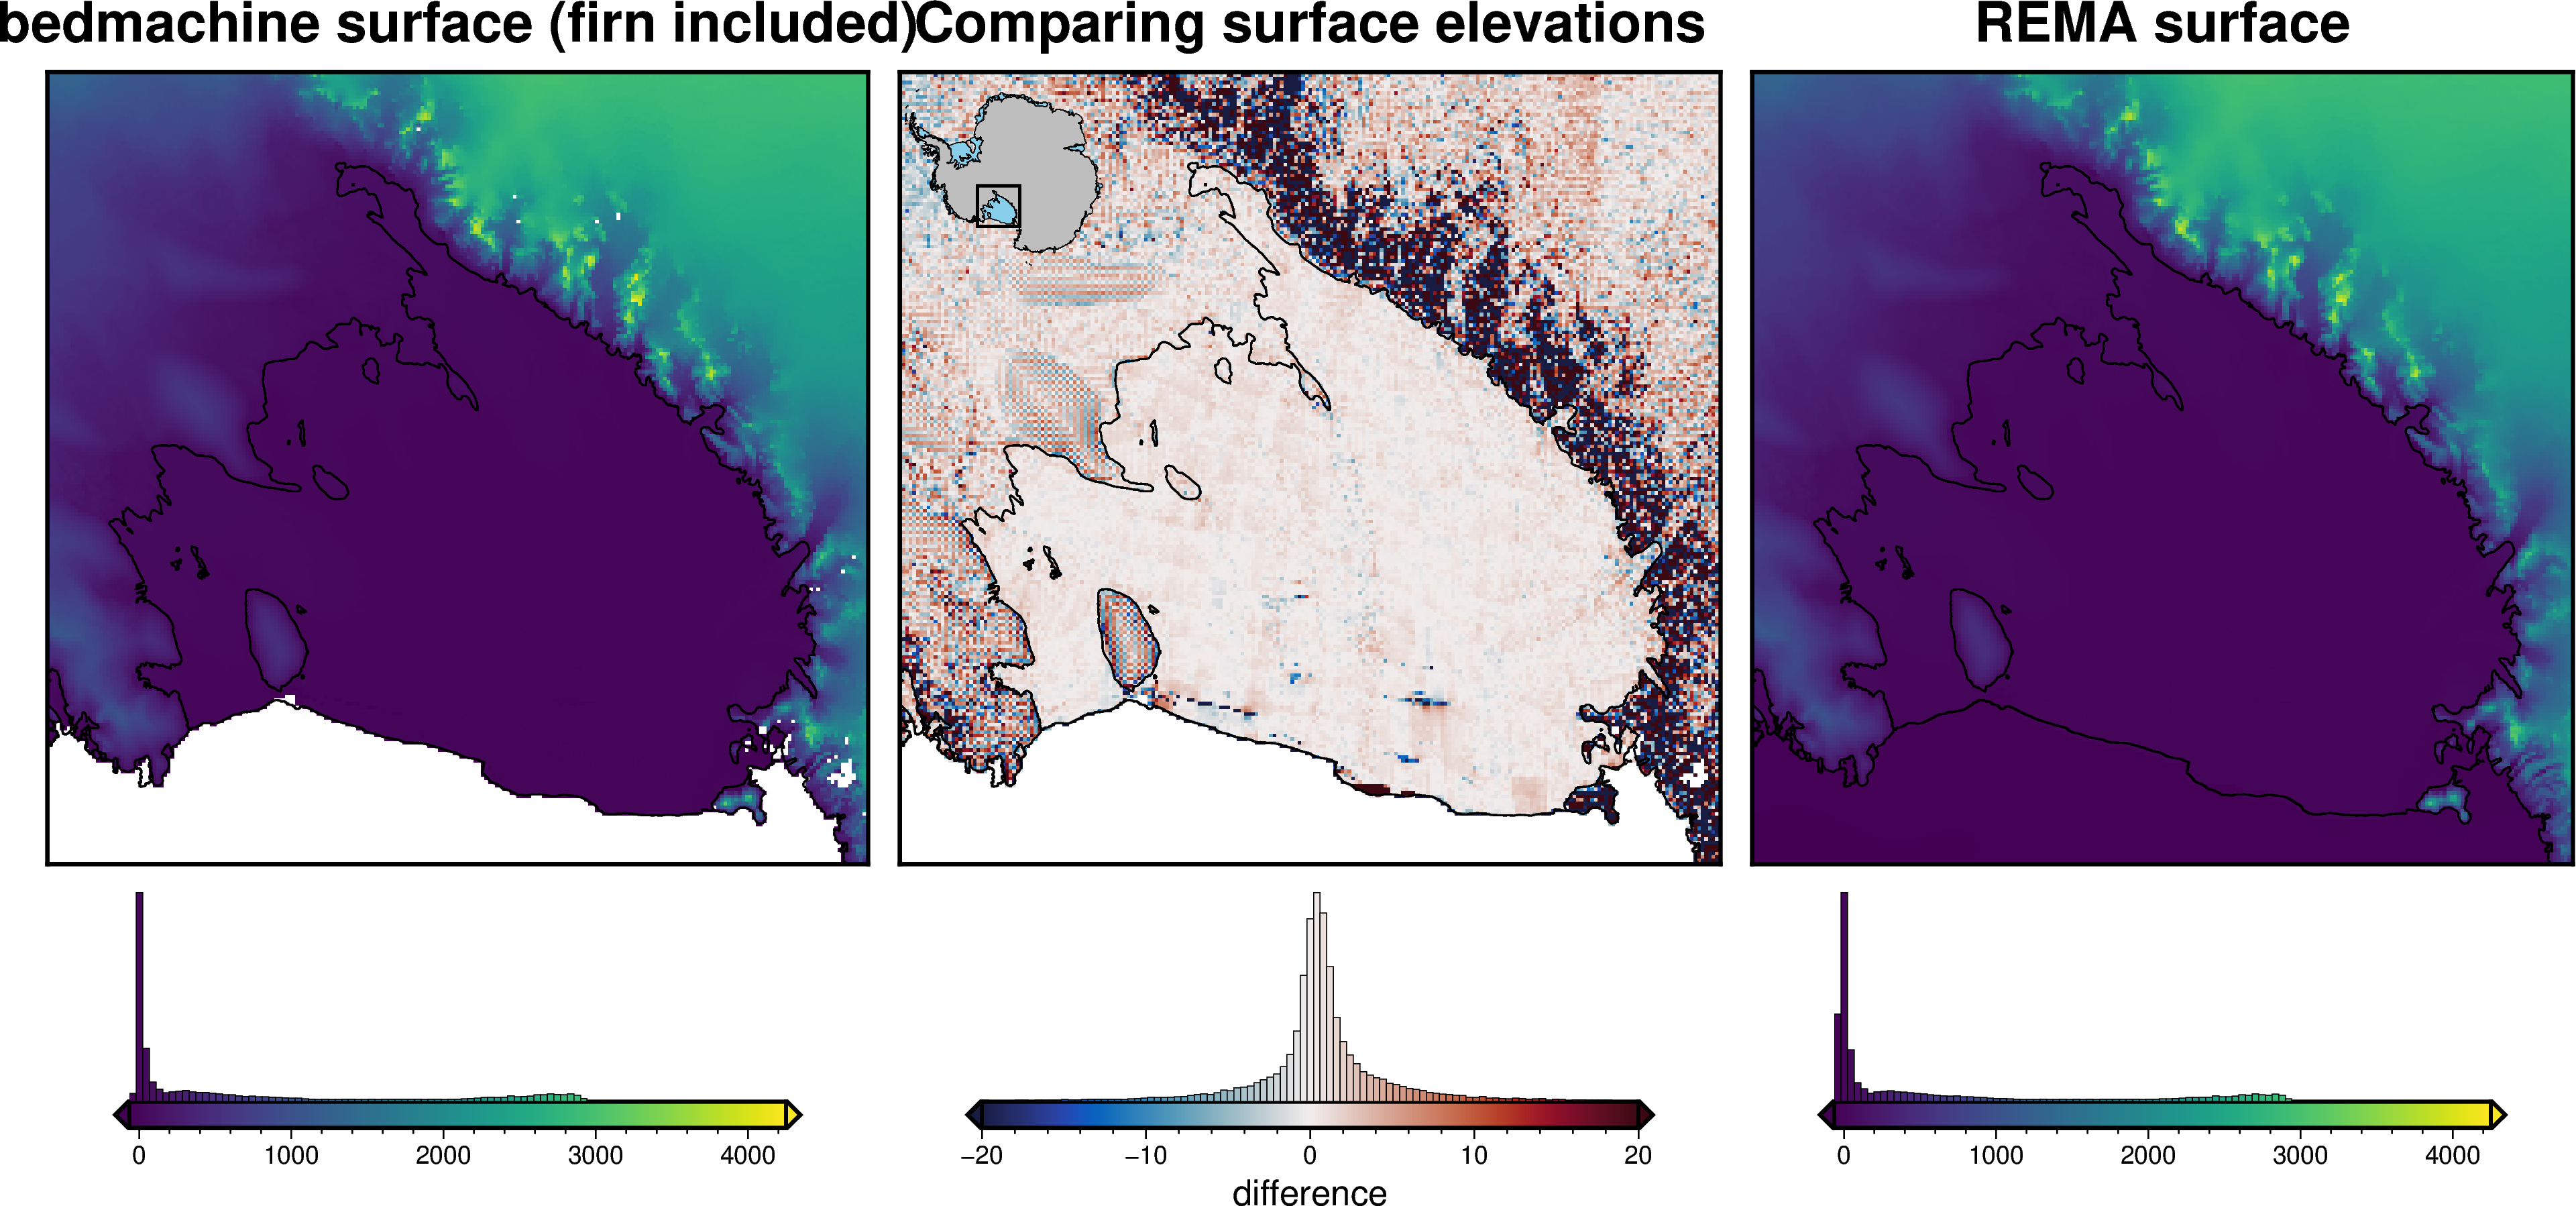

In [26]:
grids = utils.grd_compare(
    bedmachine_surface_true,
    REMA,
    plot=True,
    grid1_name="bedmachine surface (firn included)",
    grid2_name="REMA surface",
    title="Comparing surface elevations",
    diff_maxabs=20,
    hist=True,
    rmse_in_title=False,
)

# Make prism layers

## Bedmap2 prisms

In [27]:
# create prisms around ice surface
# positive densities above reference, negative below
bedmap2_ice_surface_prisms = inv_utils.grids_to_prisms(
    top = bedmap2_surface,
    bottom = bedmap2_surface.values.mean(),
    density=xr.where(bedmap2_surface>=bedmap2_surface.values.mean(), 917, -917),
)

bedmap2_surface_prisms = inv_utils.grids_to_prisms(
    top = bedmap2_surface,
    bottom = bedmap2_surface.values.mean(),
    density=xr.where(bedmap2_surface>=bedmap2_surface.values.mean(), 917, -917),
)

# plots.show_prism_layers(
#     [bedmap2_ice_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

## Bedmachine ice-surface prisms

In [28]:
# create prisms around ice surface
# positive densities above reference, negative below
bedmachine_surface_ice_eq_prisms = inv_utils.grids_to_prisms(
    top = bedmachine_surface_ice_eq,
    bottom = bedmachine_surface_ice_eq.values.mean(),
    density=xr.where(bedmachine_surface_ice_eq>=bedmachine_surface_ice_eq.values.mean(), 917, -917),
)

## Bedmachine prisms (true geometry)

In [29]:
# create prisms around ice surface
# positive densities above reference, negative below
bedmachine_surface_true_prisms = inv_utils.grids_to_prisms(
    top = bedmachine_surface_true,
    bottom = bedmachine_surface_true.values.mean(),
    density=xr.where(bedmachine_surface_true>=bedmachine_surface_true.values.mean(), 917, -917),
)

## Bedmachine prisms (ice and firn)

In [10]:
# create prisms around ice surface
# positive densities above reference, negative below
bedmachine_firn_prisms = inv_utils.grids_to_prisms(
    top = bedmachine_surface_true,
    bottom = bedmachine_surface_true.values.mean(),
    density=xr.where(bedmachine_surface_true>=bedmachine_surface_true.values.mean(), 917, -917),
)

bedmachine_firn_prisms = grids_to_prisms(
    bedmachine_surface_true,
    bedmachine_surface_true - bedmachine_firn,
    density=500,
    plot=False,
)

In [11]:
bedmachine_ice_prisms_base_of_firn = grids_to_prisms(
    bedmachine_surface_true - bedmachine_firn,
    bedmachine_icebase,
    density=917,
    plot=False,
)

In [12]:
show_prism_layers(
    [bedmachine_firn_prisms, bedmachine_ice_prisms_base_of_firn],
    cmap="viridis",
    color_by="density",
    # zscale=800, # for RIS mask
    zcale=100,  # for entire region
    flip_scalars=False,
    smooth_shading=False,
    style="surface",
    show_edges=False,
    # backend='static',
)

ViewInteractiveWidget(height=768, layout=Layout(height='auto', width='100%'), width=1024)

# Forward gravity

Here, we'll use the forward gravity calculations provided by _Harmonica_ to calculate the gravity of each vertical prism. Convienently, we can do this for the entire layer of prisms, instead of for individual prisms, using **harmonica.prism_layer.gravity**.

We need to tell harmonica where (spatially) to calculate the gravity effect of the prisms. We can create a grid of evenly spaced observations points at a constant elevation.

In [13]:
spacing = 5e3
observation_points = vd.grid_coordinates(region, spacing=spacing, extra_coords=1e3)

We have 4 sets of prisms to calculate the forward gravity of
* Bedmap2 true geometry
* Bedmachine ice equivalent thickness
* Bedmachine true geometry
* Bedmachine 2 layer model

## Bedmap2 true geometry

  0%|          | 0/51513 [00:00<?, ?it/s]

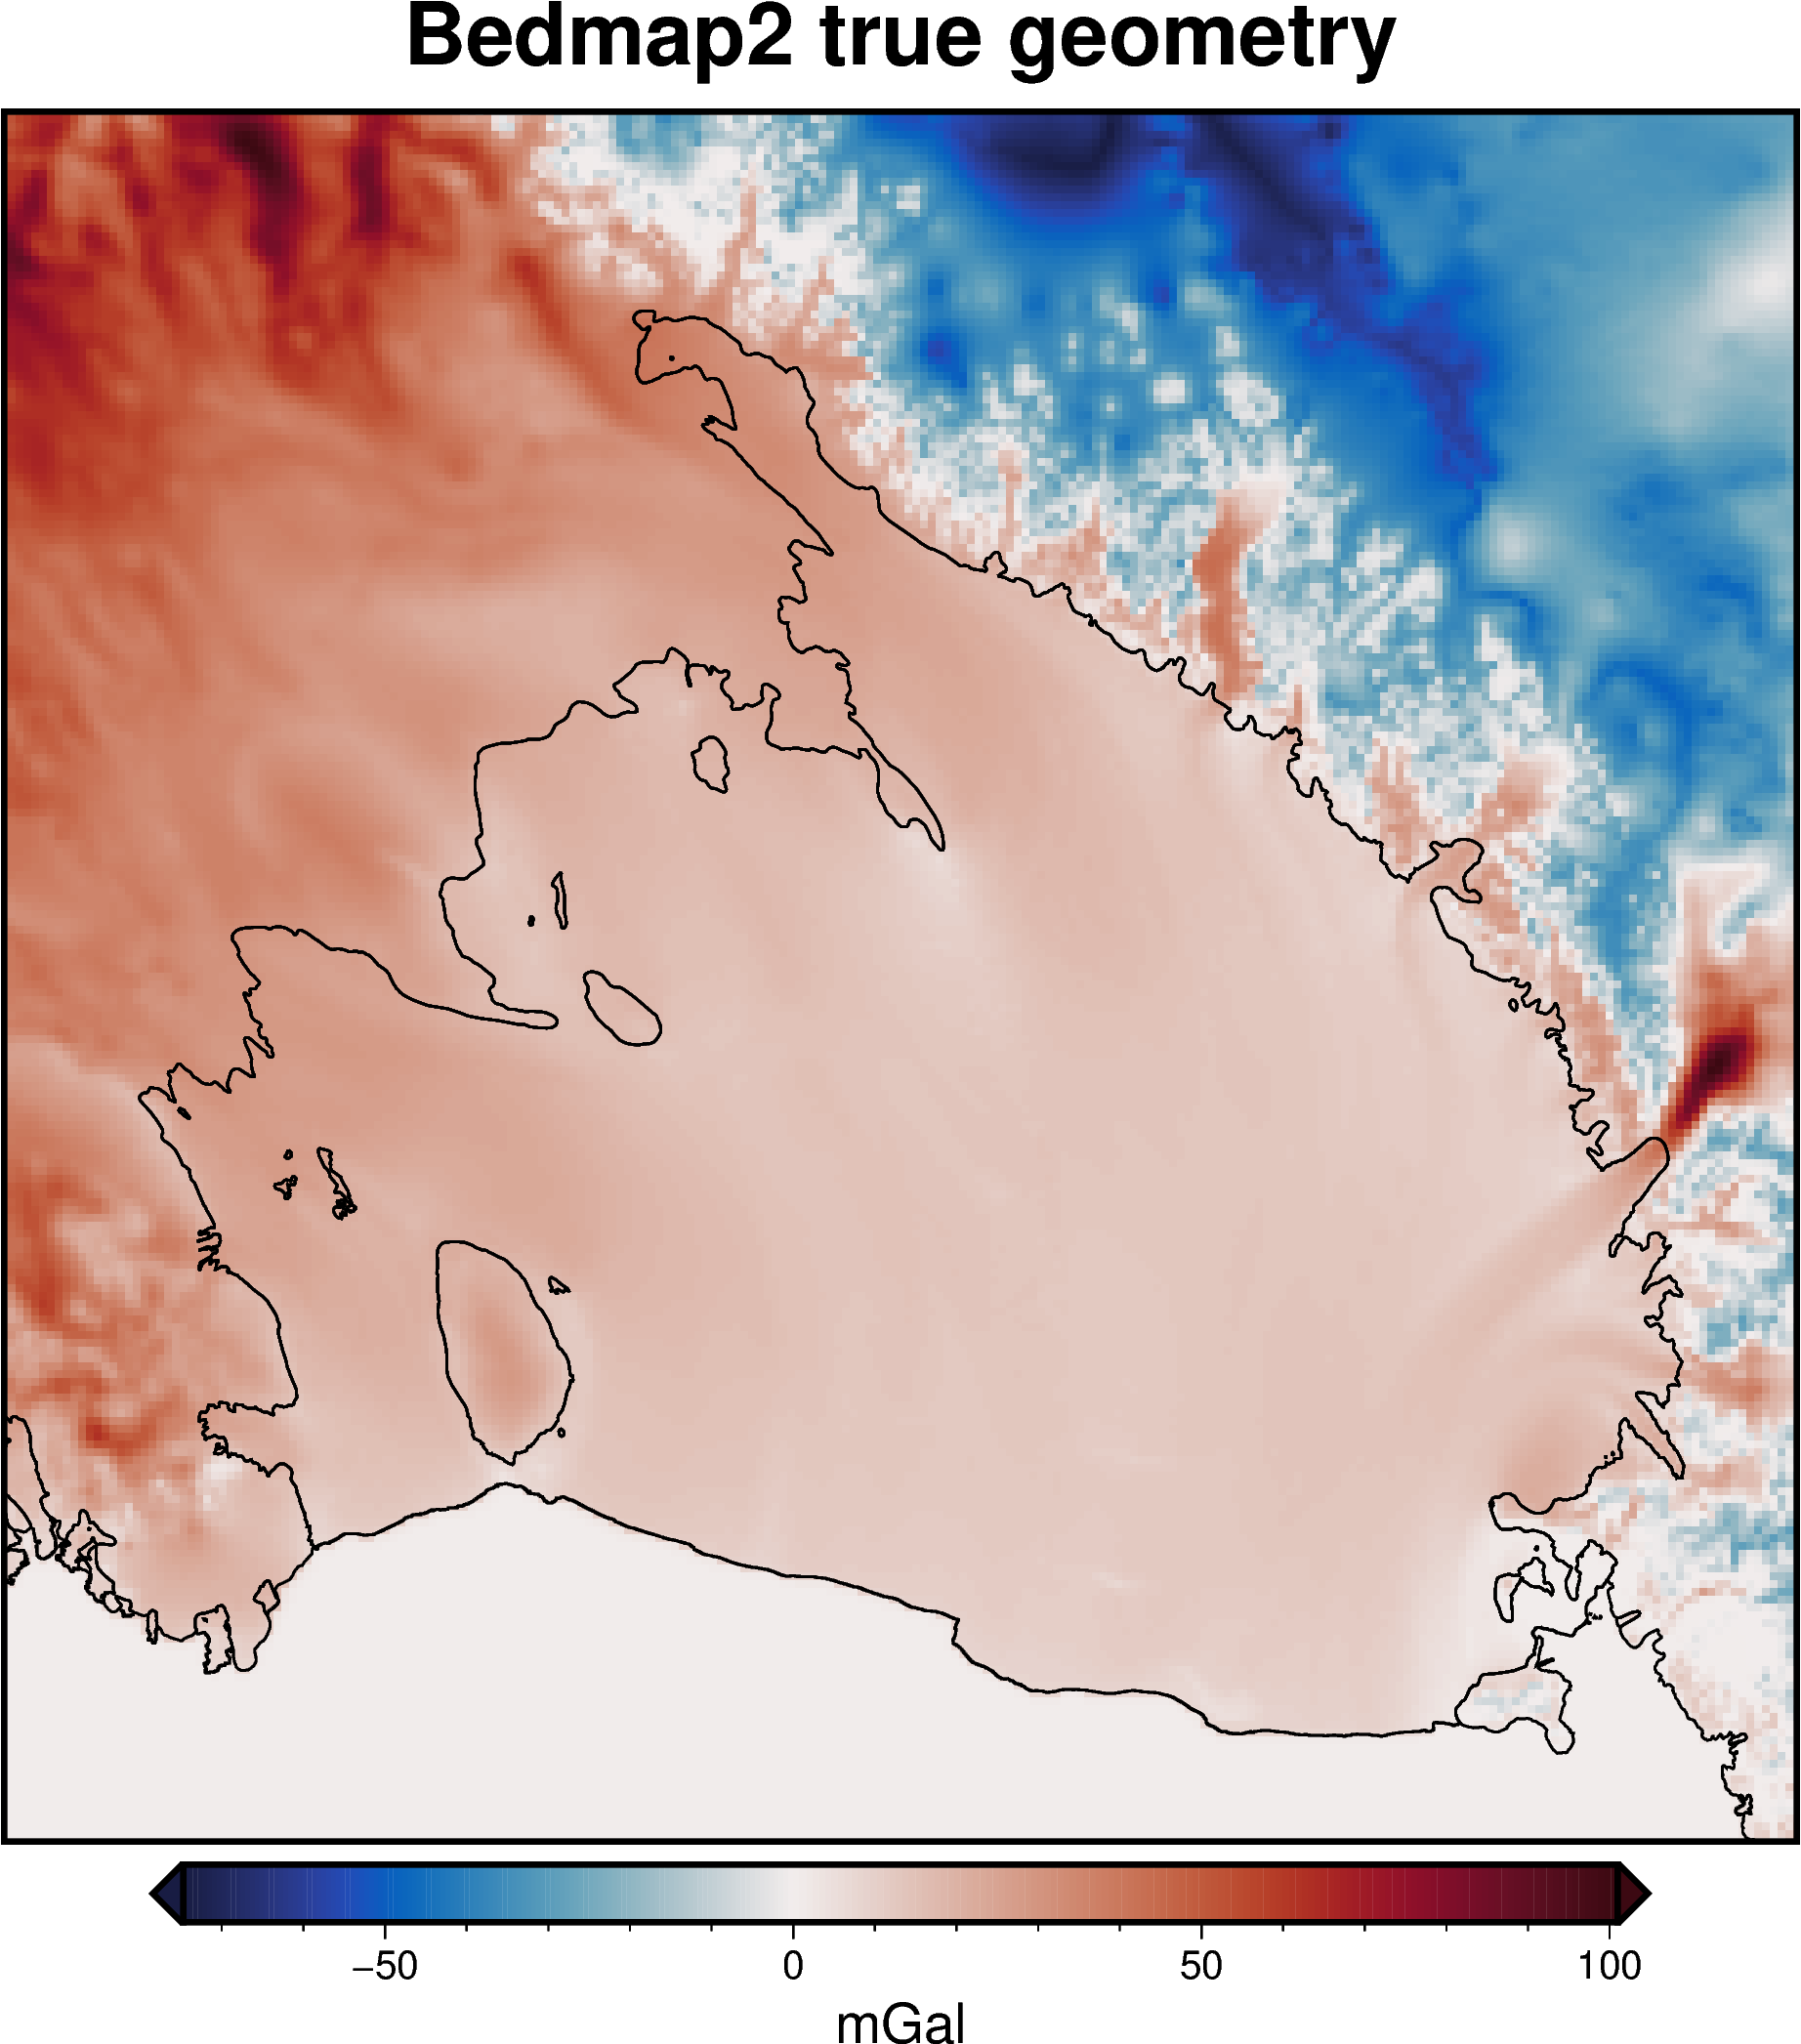

In [36]:
bedmap2_true_grav = forward_grav_of_prismlayer(
    [bedmap2_ice_prisms_true_geo],
    observation_points,
    plot=True,
    names=["Bedmap2 true geometry"],
)[0]

## Bedmachine ice equivalent

  0%|          | 0/51513 [00:00<?, ?it/s]

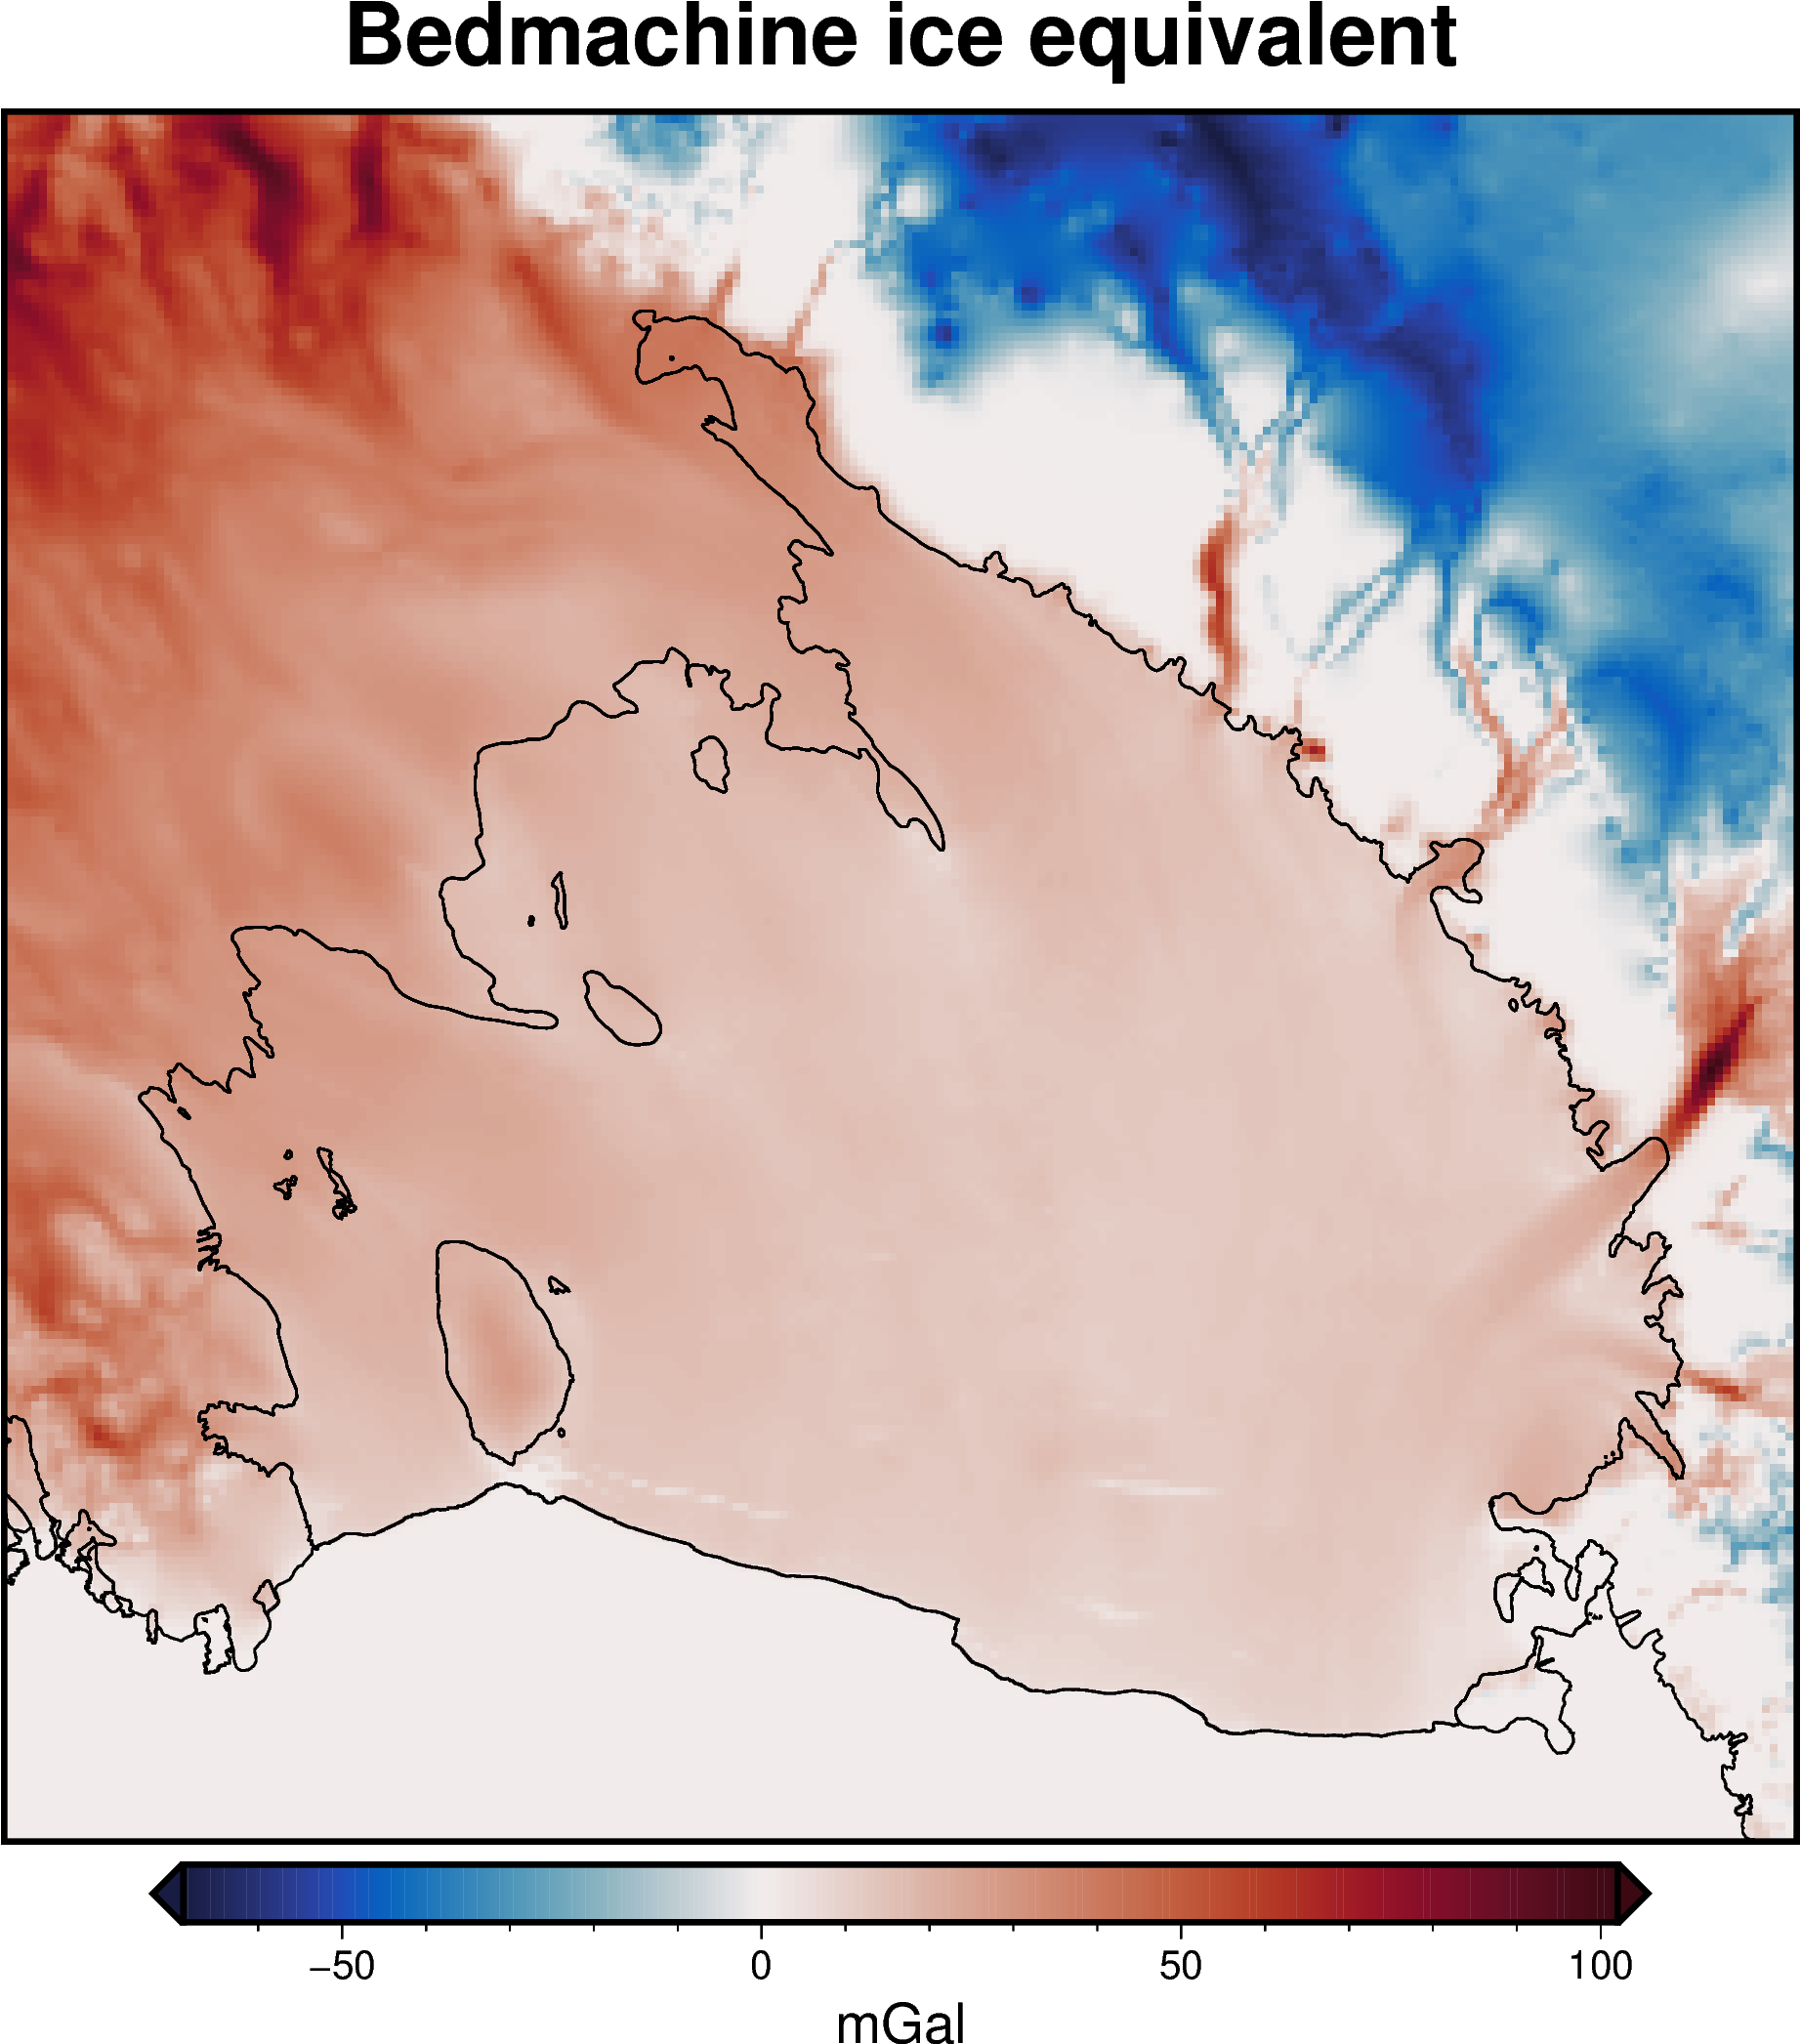

In [14]:
bedmachine_ice_eq_grav = forward_grav_of_prismlayer(
    [bedmachine_ice_eq_prisms],
    observation_points,
    plot=True,
    names=["Bedmachine ice equivalent"],
)[0]

## Bedmachine true geometry

  0%|          | 0/51513 [00:00<?, ?it/s]

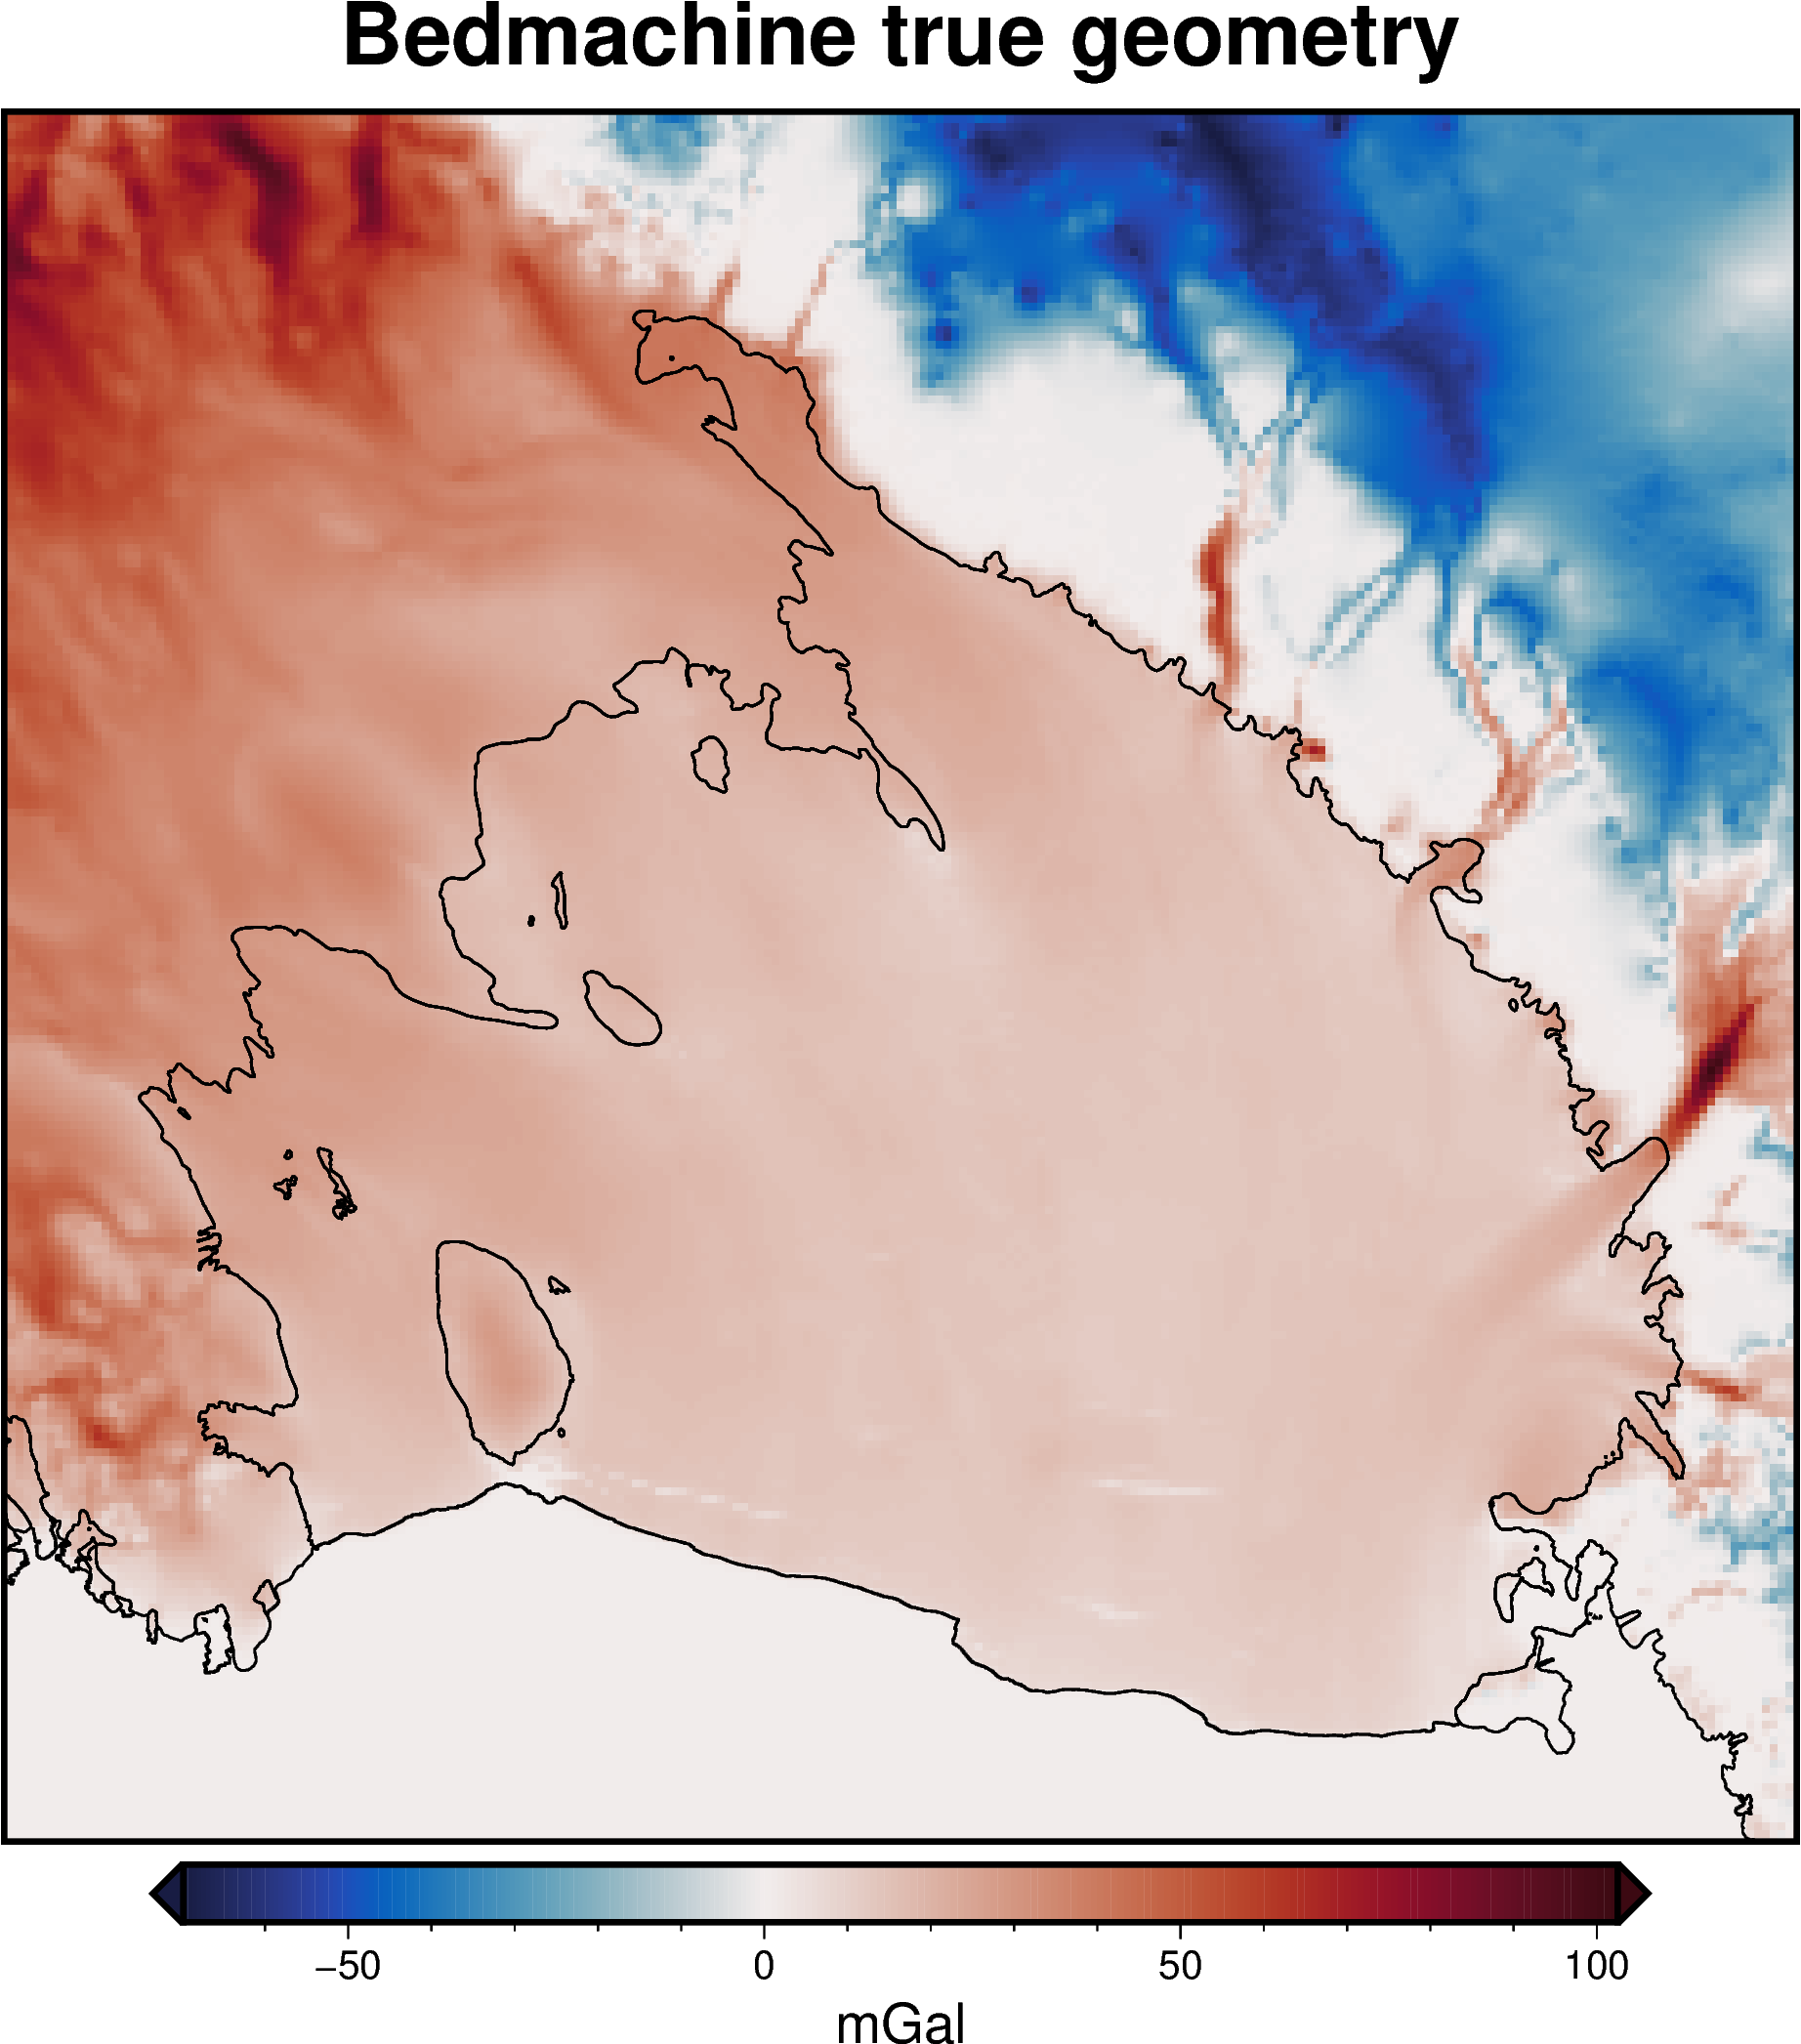

In [38]:
bedmachine_true_grav = forward_grav_of_prismlayer(
    [bedmachine_ice_prisms_true_geo],
    observation_points,
    plot=True,
    names=["Bedmachine true geometry"],
)[0]

## Bedmachine 2 layer

  0%|          | 0/51513 [00:00<?, ?it/s]

  0%|          | 0/51513 [00:00<?, ?it/s]

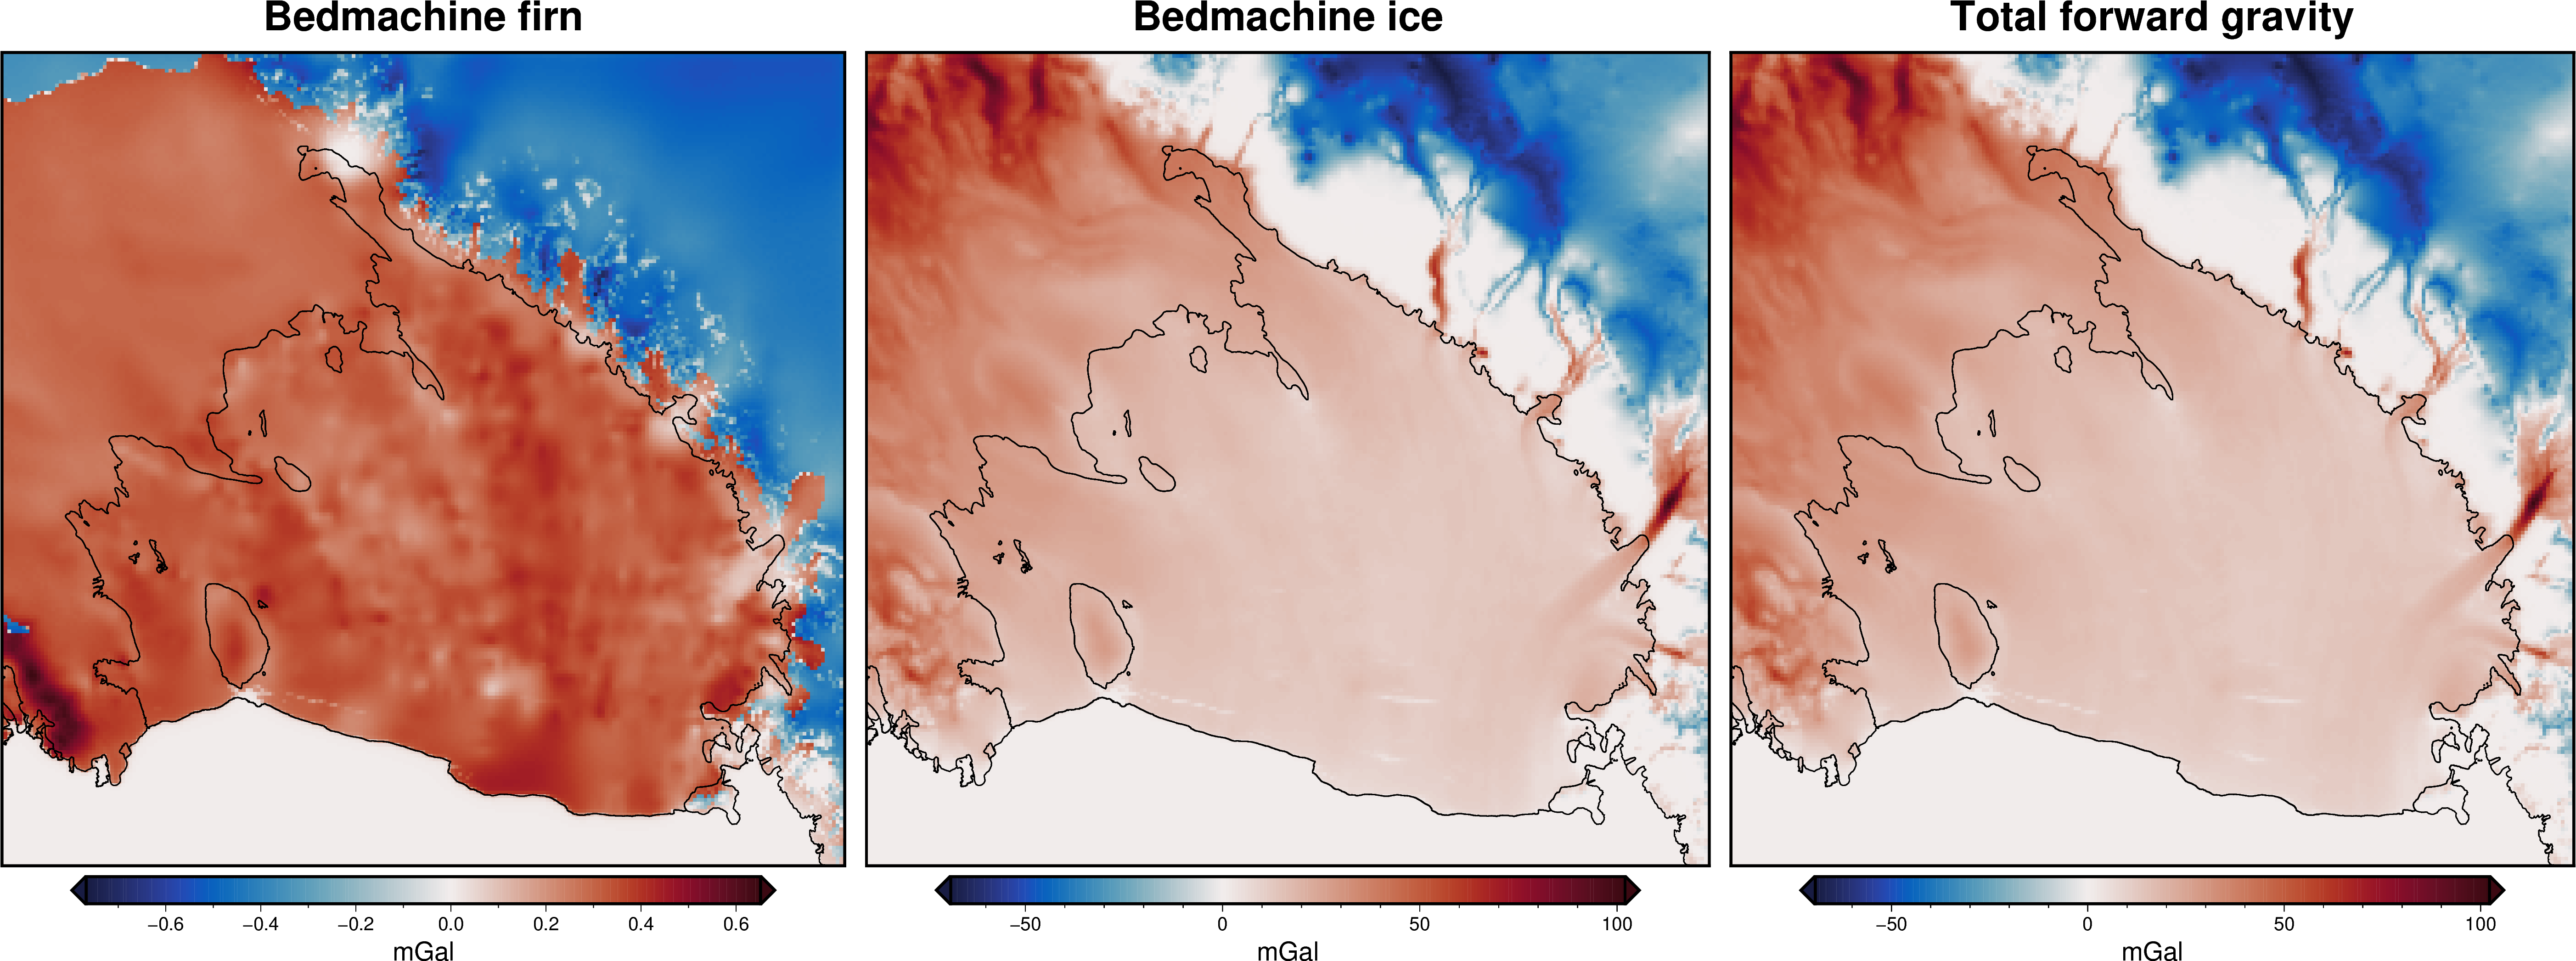

In [15]:
bedmachine_2layer_grav = forward_grav_of_prismlayer(
    [bedmachine_firn_prisms, bedmachine_ice_prisms_base_of_firn],
    observation_points,
    plot=True,
    names=["Bedmachine firn", "Bedmachine ice"],
)

# Compare results

returning original grid
returning original grid


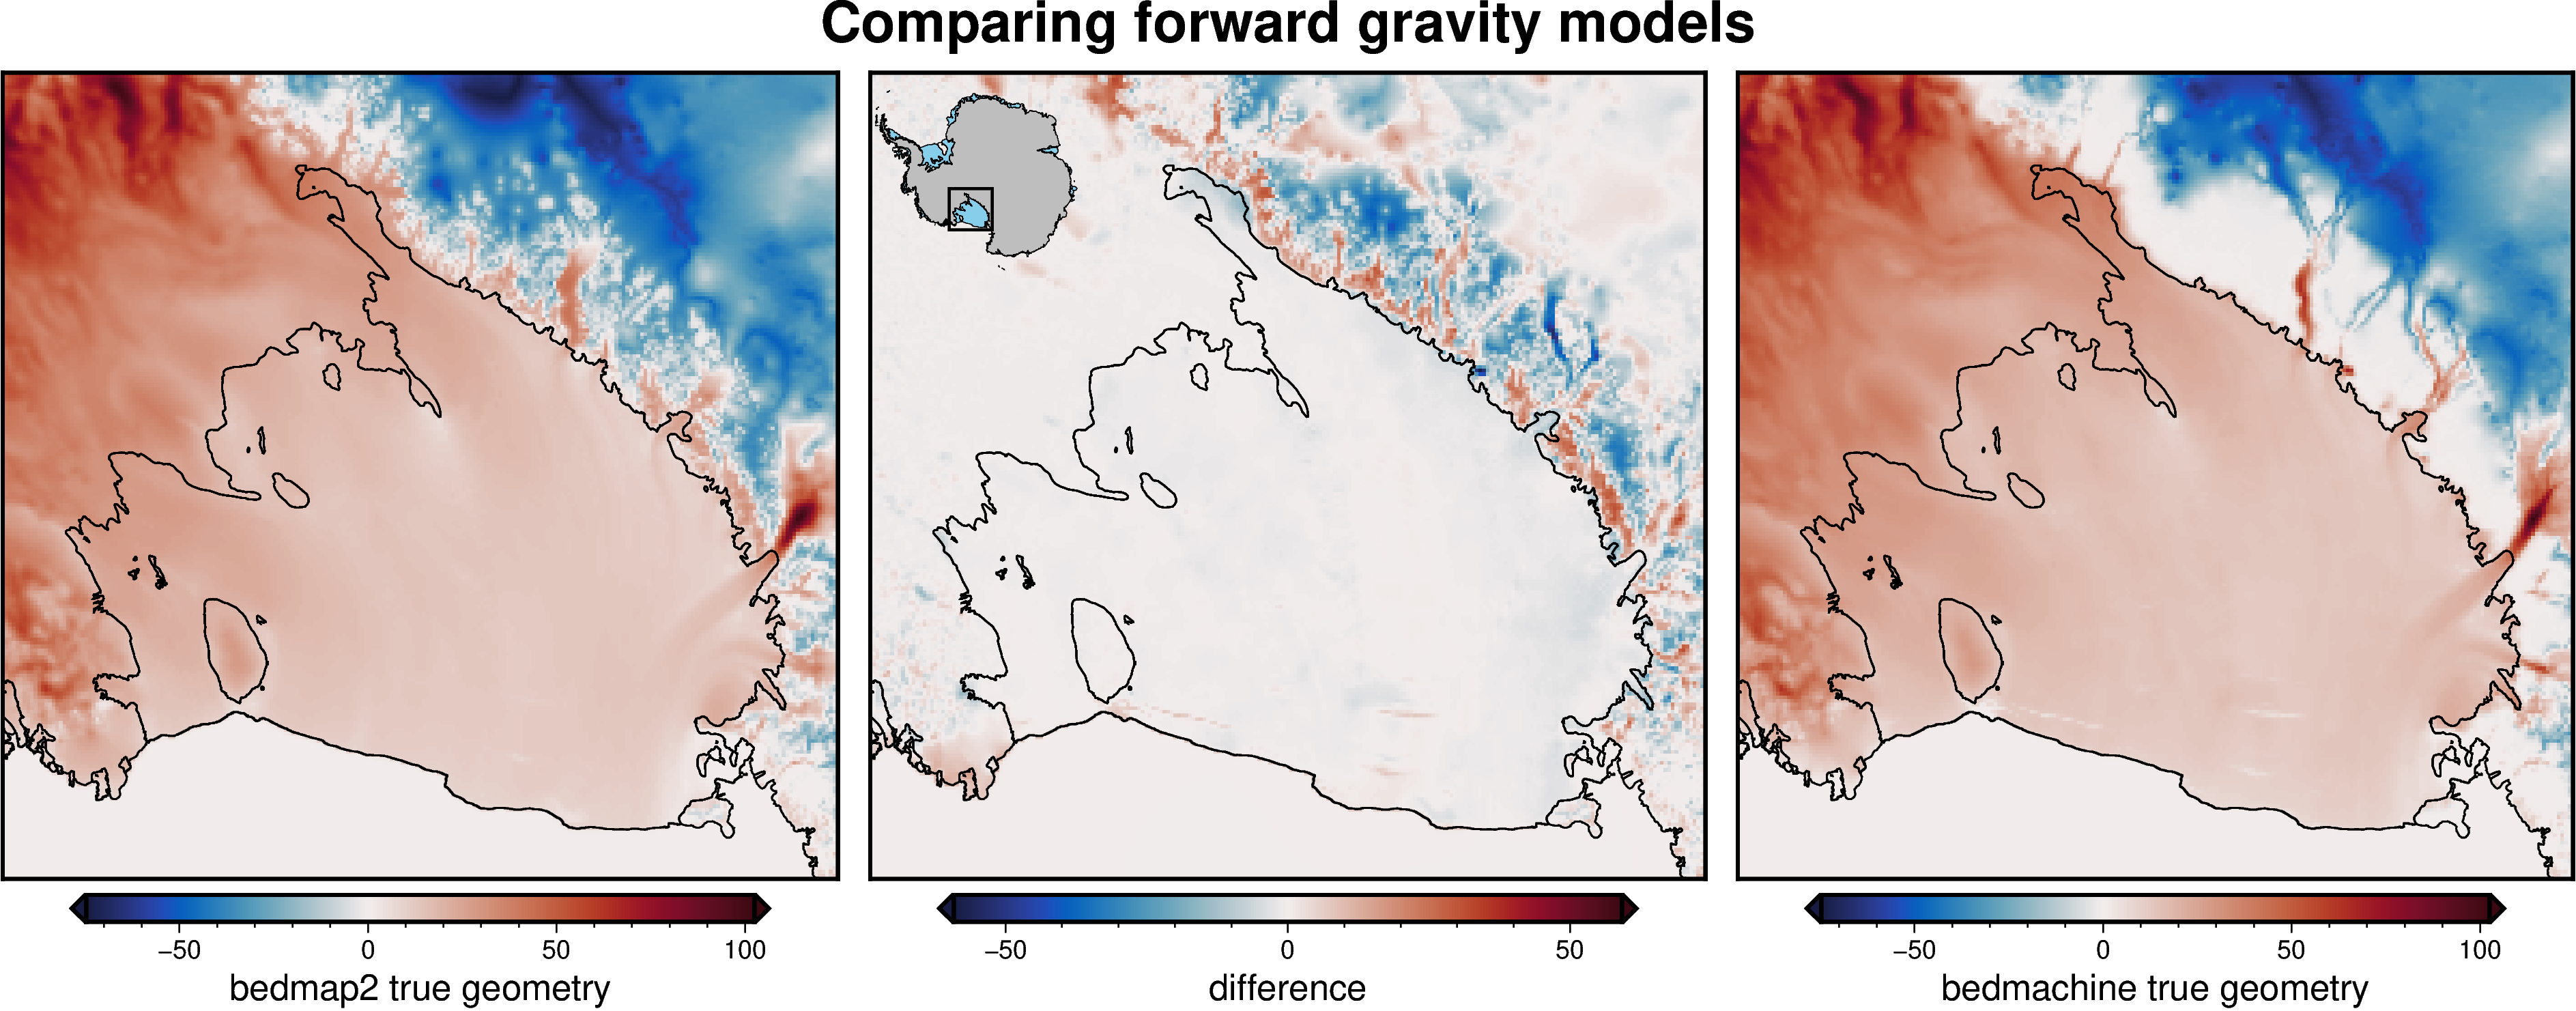

In [40]:
grids = utils.grd_compare(
    bedmap2_true_grav,
    bedmachine_true_grav,
    plot=True,
    cmap="balance+h0",
    title="Comparing forward gravity models",
    grid1_name="bedmap2 true geometry",
    grid2_name="bedmachine true geometry",
)

returning original grid
returning original grid


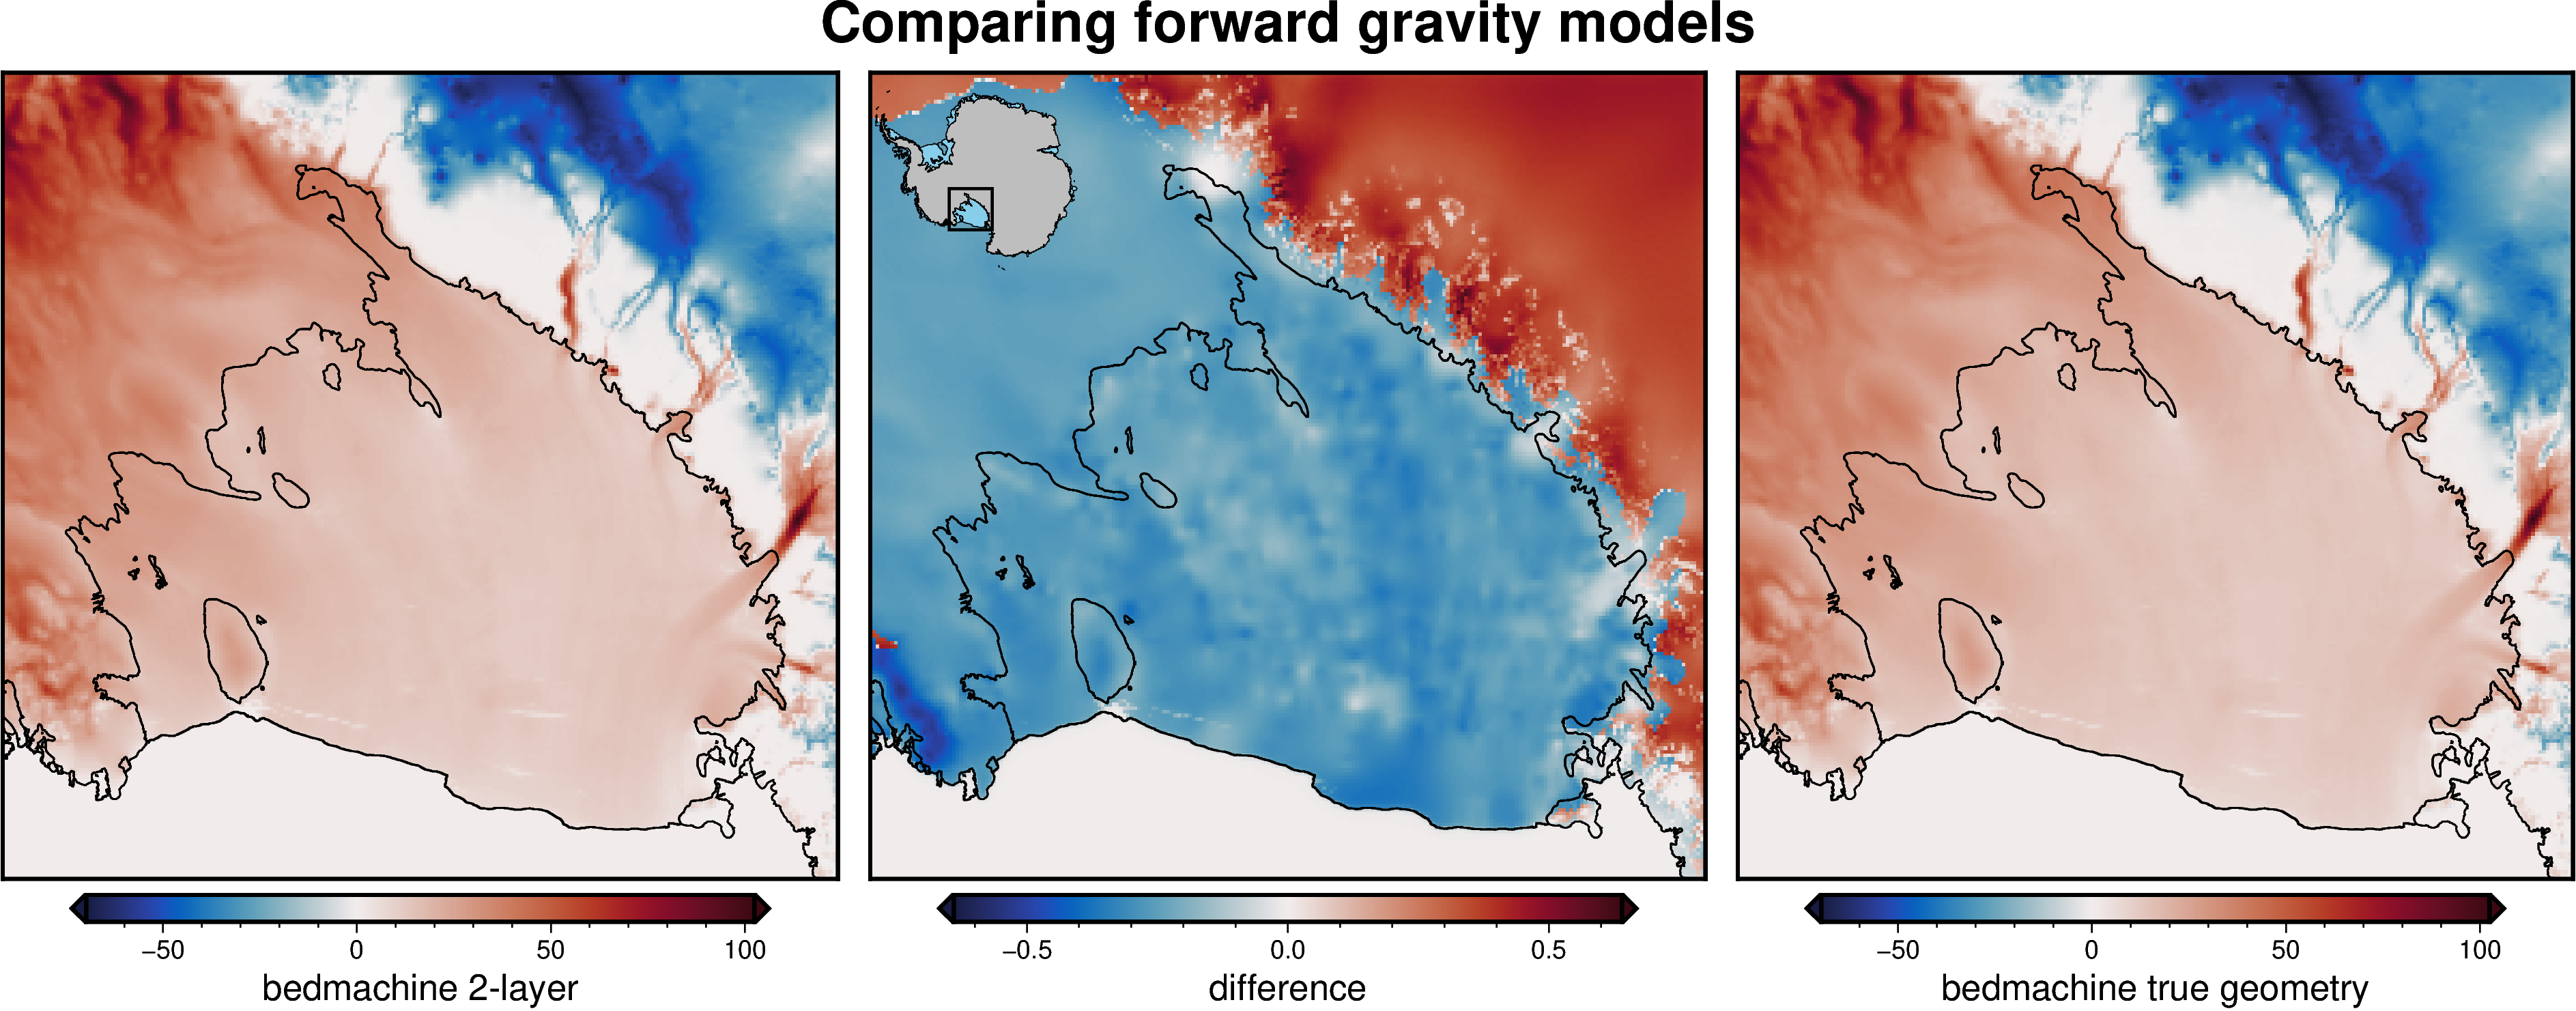

In [45]:
grids = utils.grd_compare(
    bedmachine_2layer_grav[-1],
    bedmachine_true_grav,
    plot=True,
    cmap="balance+h0",
    title="Comparing forward gravity models",
    grid1_name="bedmachine 2-layer",
    grid2_name="bedmachine true geometry",
)

returning original grid
returning original grid


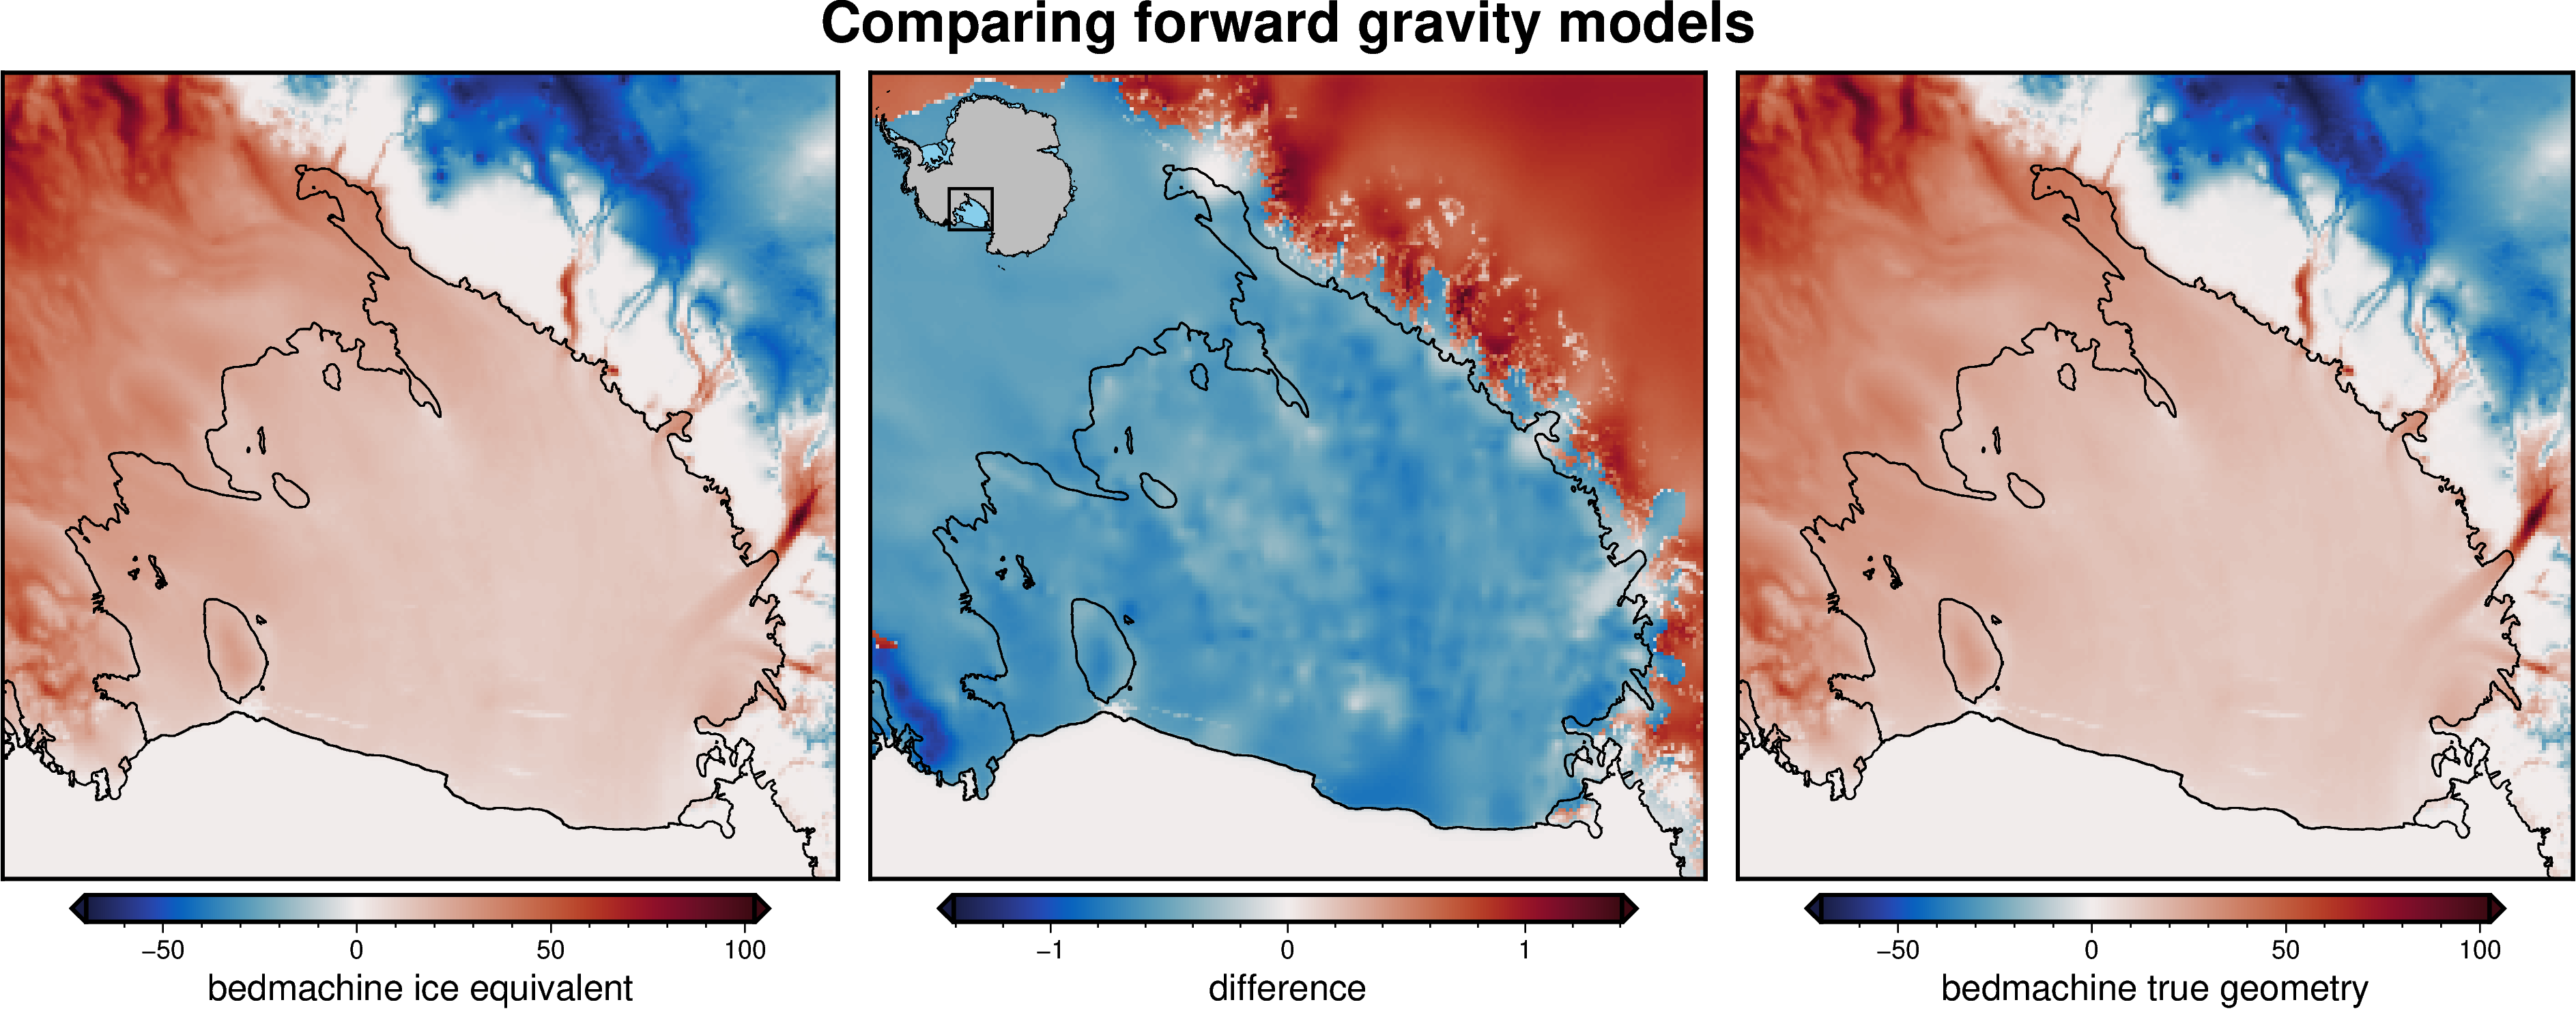

In [42]:
grids = utils.grd_compare(
    bedmachine_ice_eq_grav,
    bedmachine_true_grav,
    plot=True,
    cmap="balance+h0",
    title="Comparing forward gravity models",
    grid1_name="bedmachine ice equivalent",
    grid2_name="bedmachine true geometry",
)

returning original grid
returning original grid


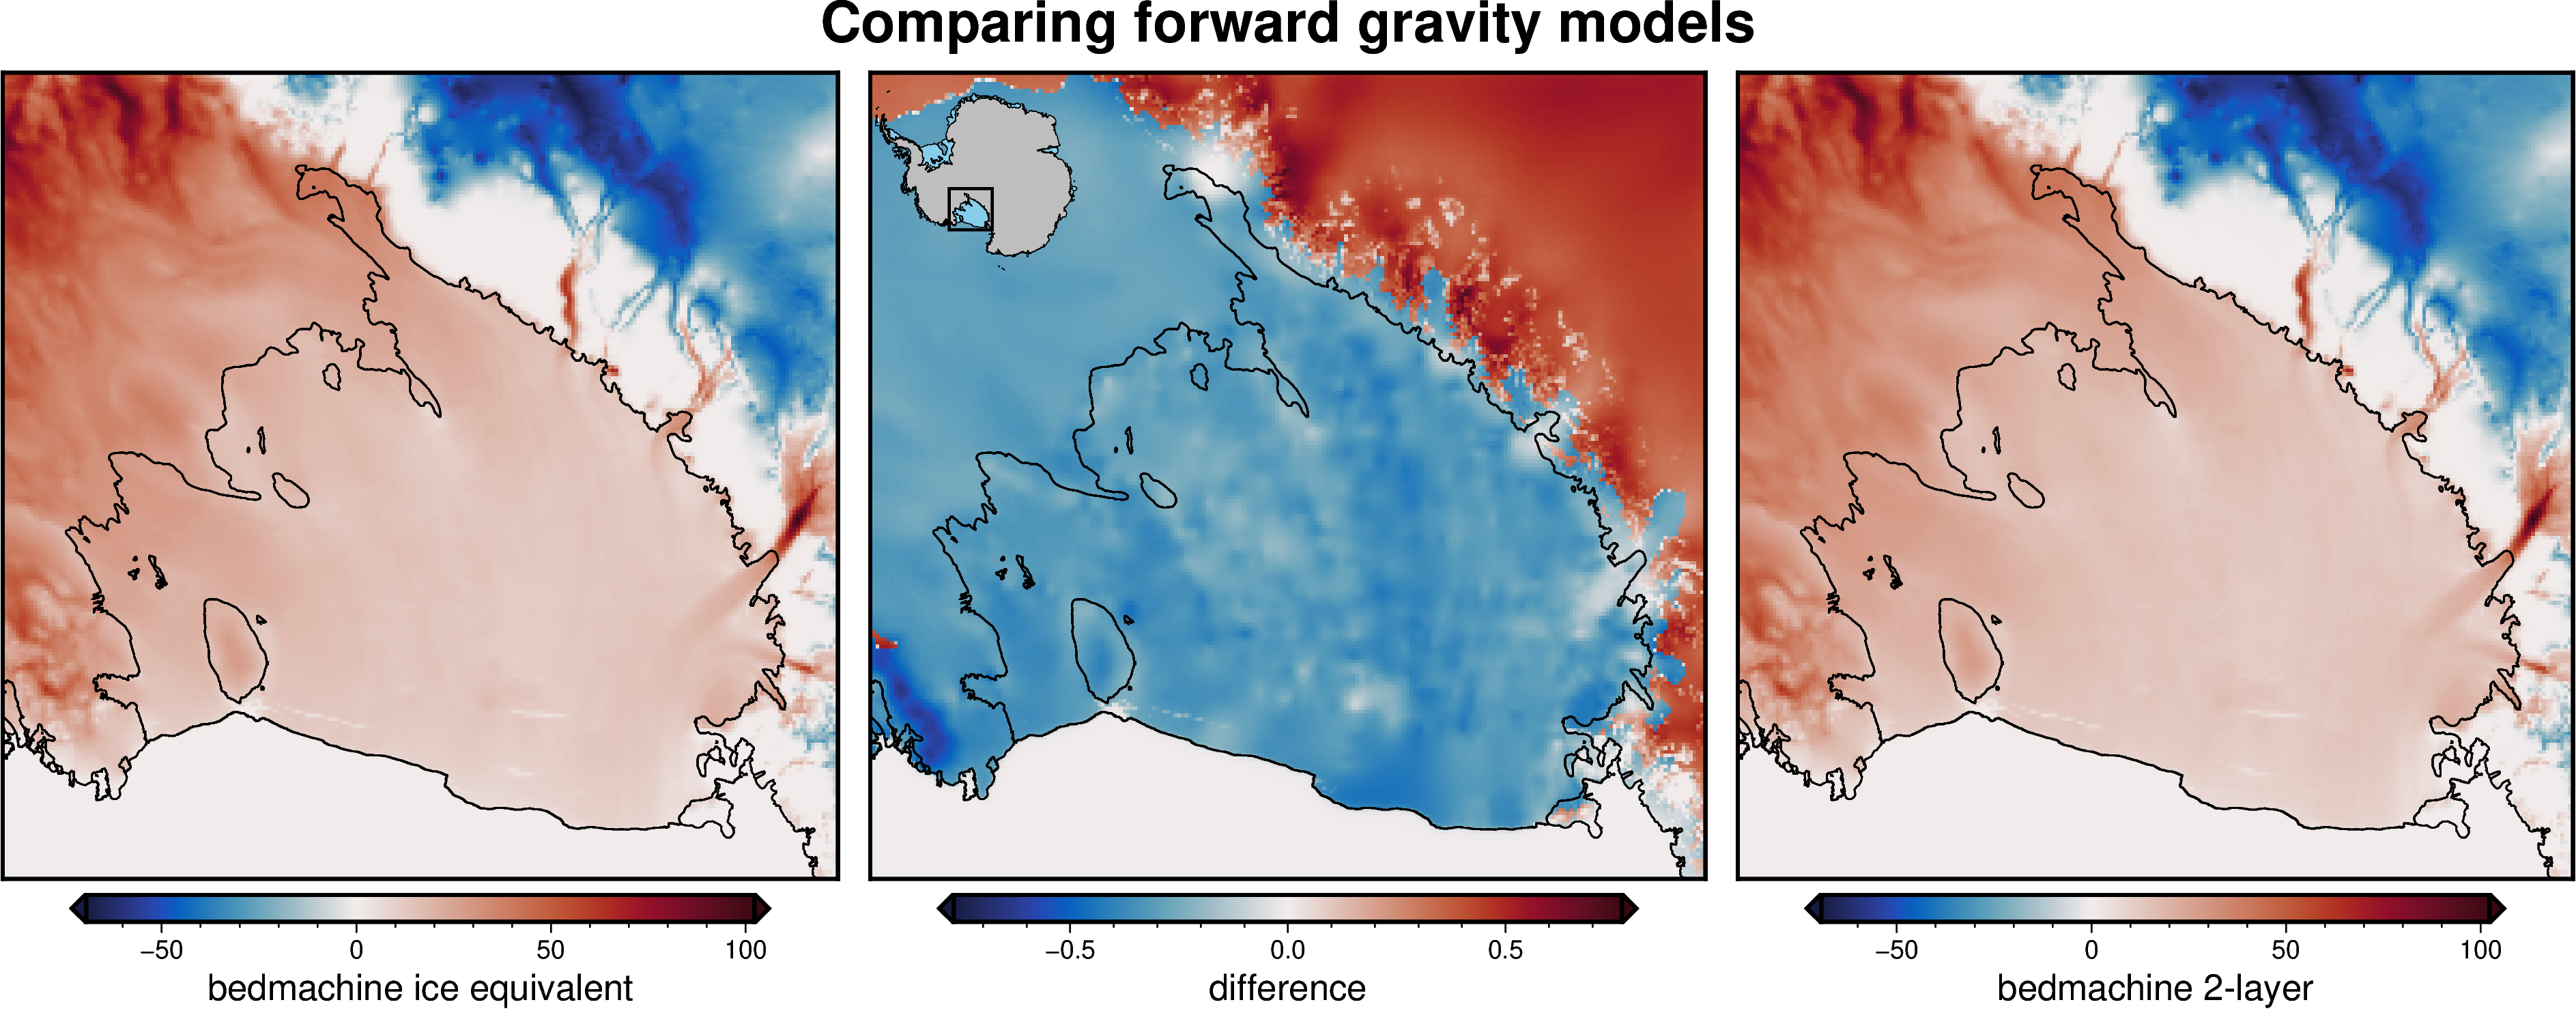

In [16]:
grids = utils.grd_compare(
    bedmachine_ice_eq_grav,
    bedmachine_2layer_grav[-1],
    plot=True,
    cmap="balance+h0",
    title="Comparing forward gravity models",
    grid1_name="bedmachine ice equivalent",
    grid2_name="bedmachine 2-layer",
)

In [44]:
# # make an ocean mask
# bedmachine_mask = fetch.bedmachine(
#     layer='mask',
#     region=region,
#     spacing=spacing,
#     registration=registration,
#     reference=reference,
#     verbose='e',
#     )
# # 0 over ocean, 1 elsewhere
# ocean_mask = bedmachine_mask.where(bedmachine_mask == 0, 1, 0)
# mask = ocean_mask.where(ocean_mask != 0)

## Firn thickness estimated from the firn depth correction

From Broeke et al. 2008: Firn depth correction along the Antarctic grounding line
doi:10.1017/S095410200800148X

$
\Delta h = h_f (1 - \rho_f / \rho_i)
$
where 

$\Delta h$ = firn depth correction

$h_f$ = firn thickness

$\rho_f$ = firn average density

$\rho_i$ = ice average density

Solving for $h_f$

$
h_f = \Delta h / (1 - \rho_f / \rho_i)
$

"Indeed, average firn density of the layer that extends from the surface to close-off depth typically varies less than 5% from a mean value of 650 kg m23, with values ranging from $625 kg m^{-3}$ in the eastern Ross Ice Shelf to $675 kg m^{-3}$ in high accumulation coastal areas (not shown)." 
Broeke et al. 2008: Depth and Density of the Antarctic Firn Layer

with $\rho_f = 650 kg m^{-3}$ and $\rho_i = 917 kg m^{-3}$

$
h_f \approx \Delta h / 0.2911668
$

In [5]:
constant = 1 - (650 / 917)
constant

0.29116684841875684

### Broeke et al. 2018 firn correction

In [17]:
# Get a firn depth correction model:
# from https://doi.pangaea.de/10.1594/PANGAEA.734145
# Van den Broeke, M. R., van de Berg, W. J., and van Meijgaard, E.:
# Firn depth correction along the Antarctic grounding line, Antarct. Sci., 20(5), 513-517,
# doi:10.1017/S095410200800148X, 2008.
fname = r"C:\Users\matthewt\Downloads\ALBMAPv1.nc\ALBMAPv1.nc"
albmap = xr.open_dataset(fname)
# albmap

# extract the fir depth corr dataarray and resample to match other grids
broeke_firn_depth_corr = fetch.resample_grid(
    albmap.firn, region=region, spacing=spacing, registration="g"
)

# convert to firn thickness
broeke_firn_thickness = broeke_firn_depth_corr / constant

returning grid with new region and/or registration, same spacing


returning original grid
returning original grid


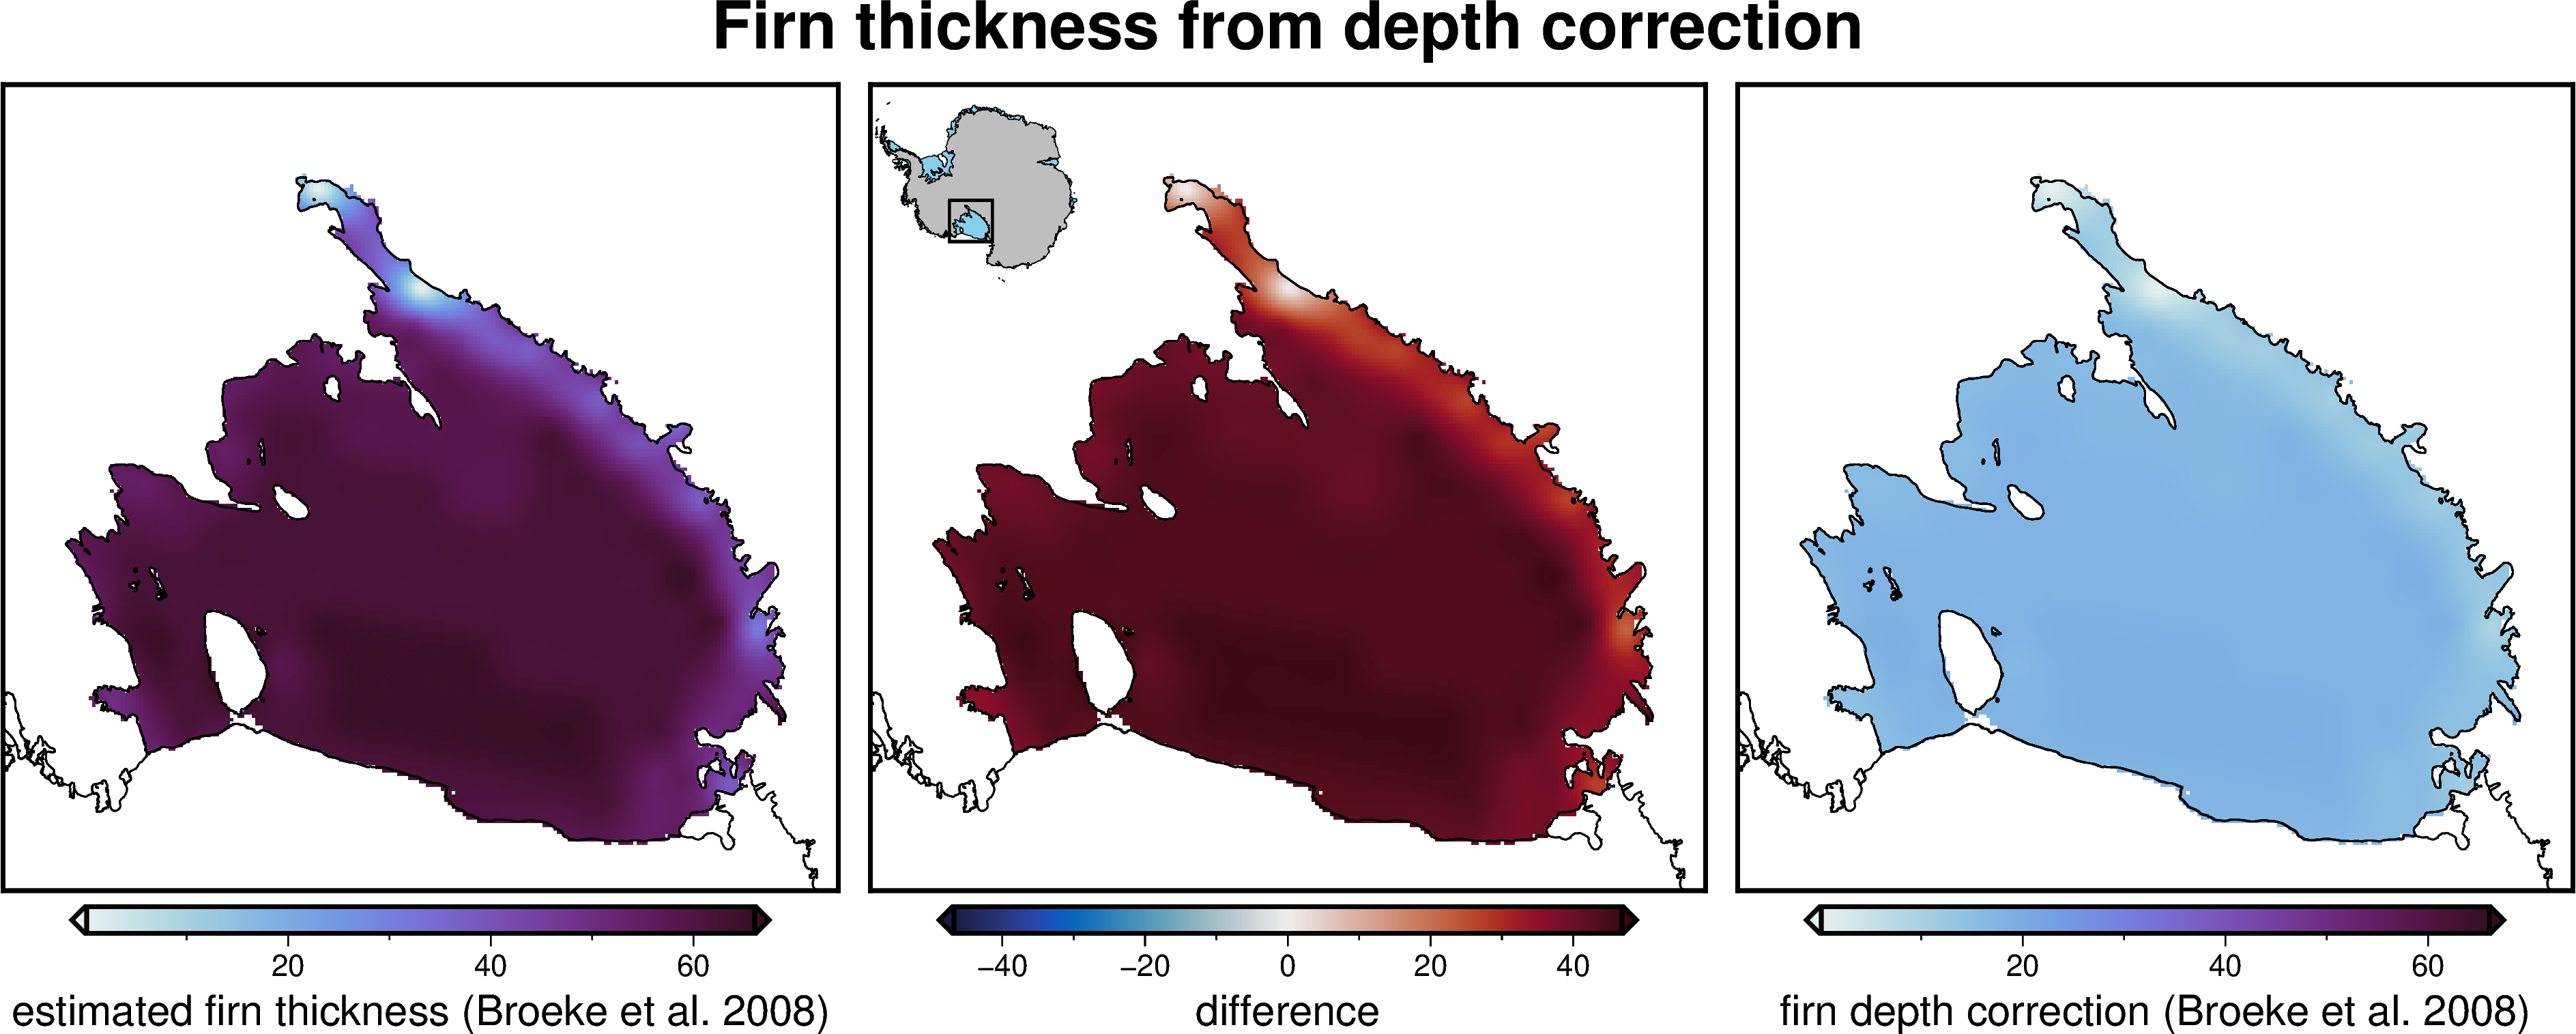

In [19]:
grids = utils.grd_compare(
    broeke_firn_thickness * mask,
    broeke_firn_depth_corr * mask,
    plot=True,
    grid1_name="estimated firn thickness (Broeke et al. 2008)",
    grid2_name="firn depth correction (Broeke et al. 2008)",
    title="Firn thickness from depth correction",
    cmap="dense",
)

### Bedmachine firn correction

returning original grid
returning original grid


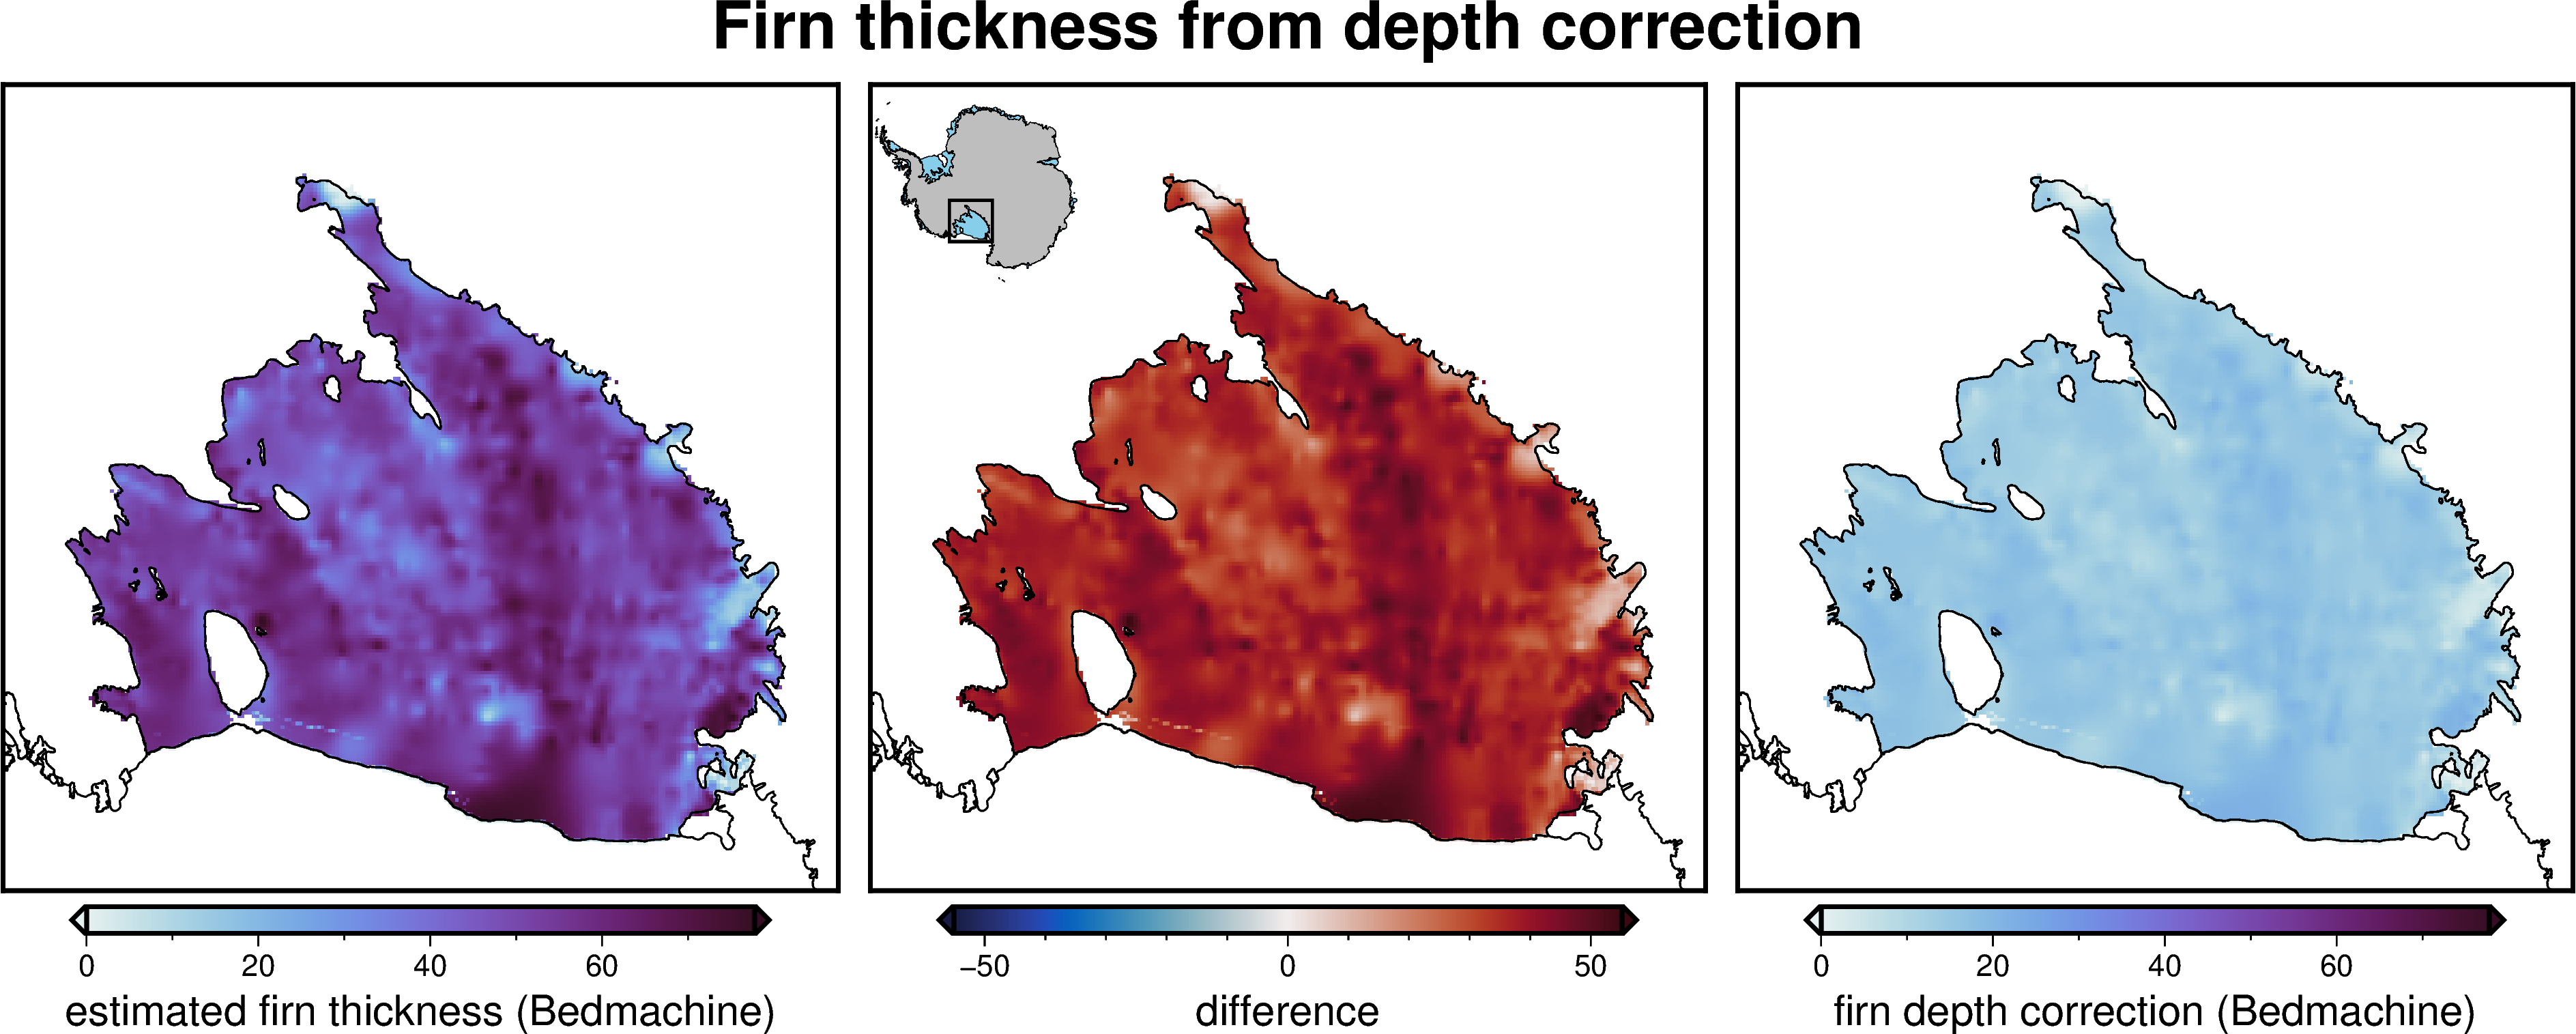

In [20]:
# convert to firn thickness
bedmachine_firn_thickness = bedmachine_firn / constant

grids = utils.grd_compare(
    bedmachine_firn_thickness * mask,
    bedmachine_firn * mask,
    plot=True,
    grid1_name="estimated firn thickness (Bedmachine)",
    grid2_name="firn depth correction (Bedmachine)",
    title="Firn thickness from depth correction",
    cmap="dense",
)

returning original grid
returning original grid


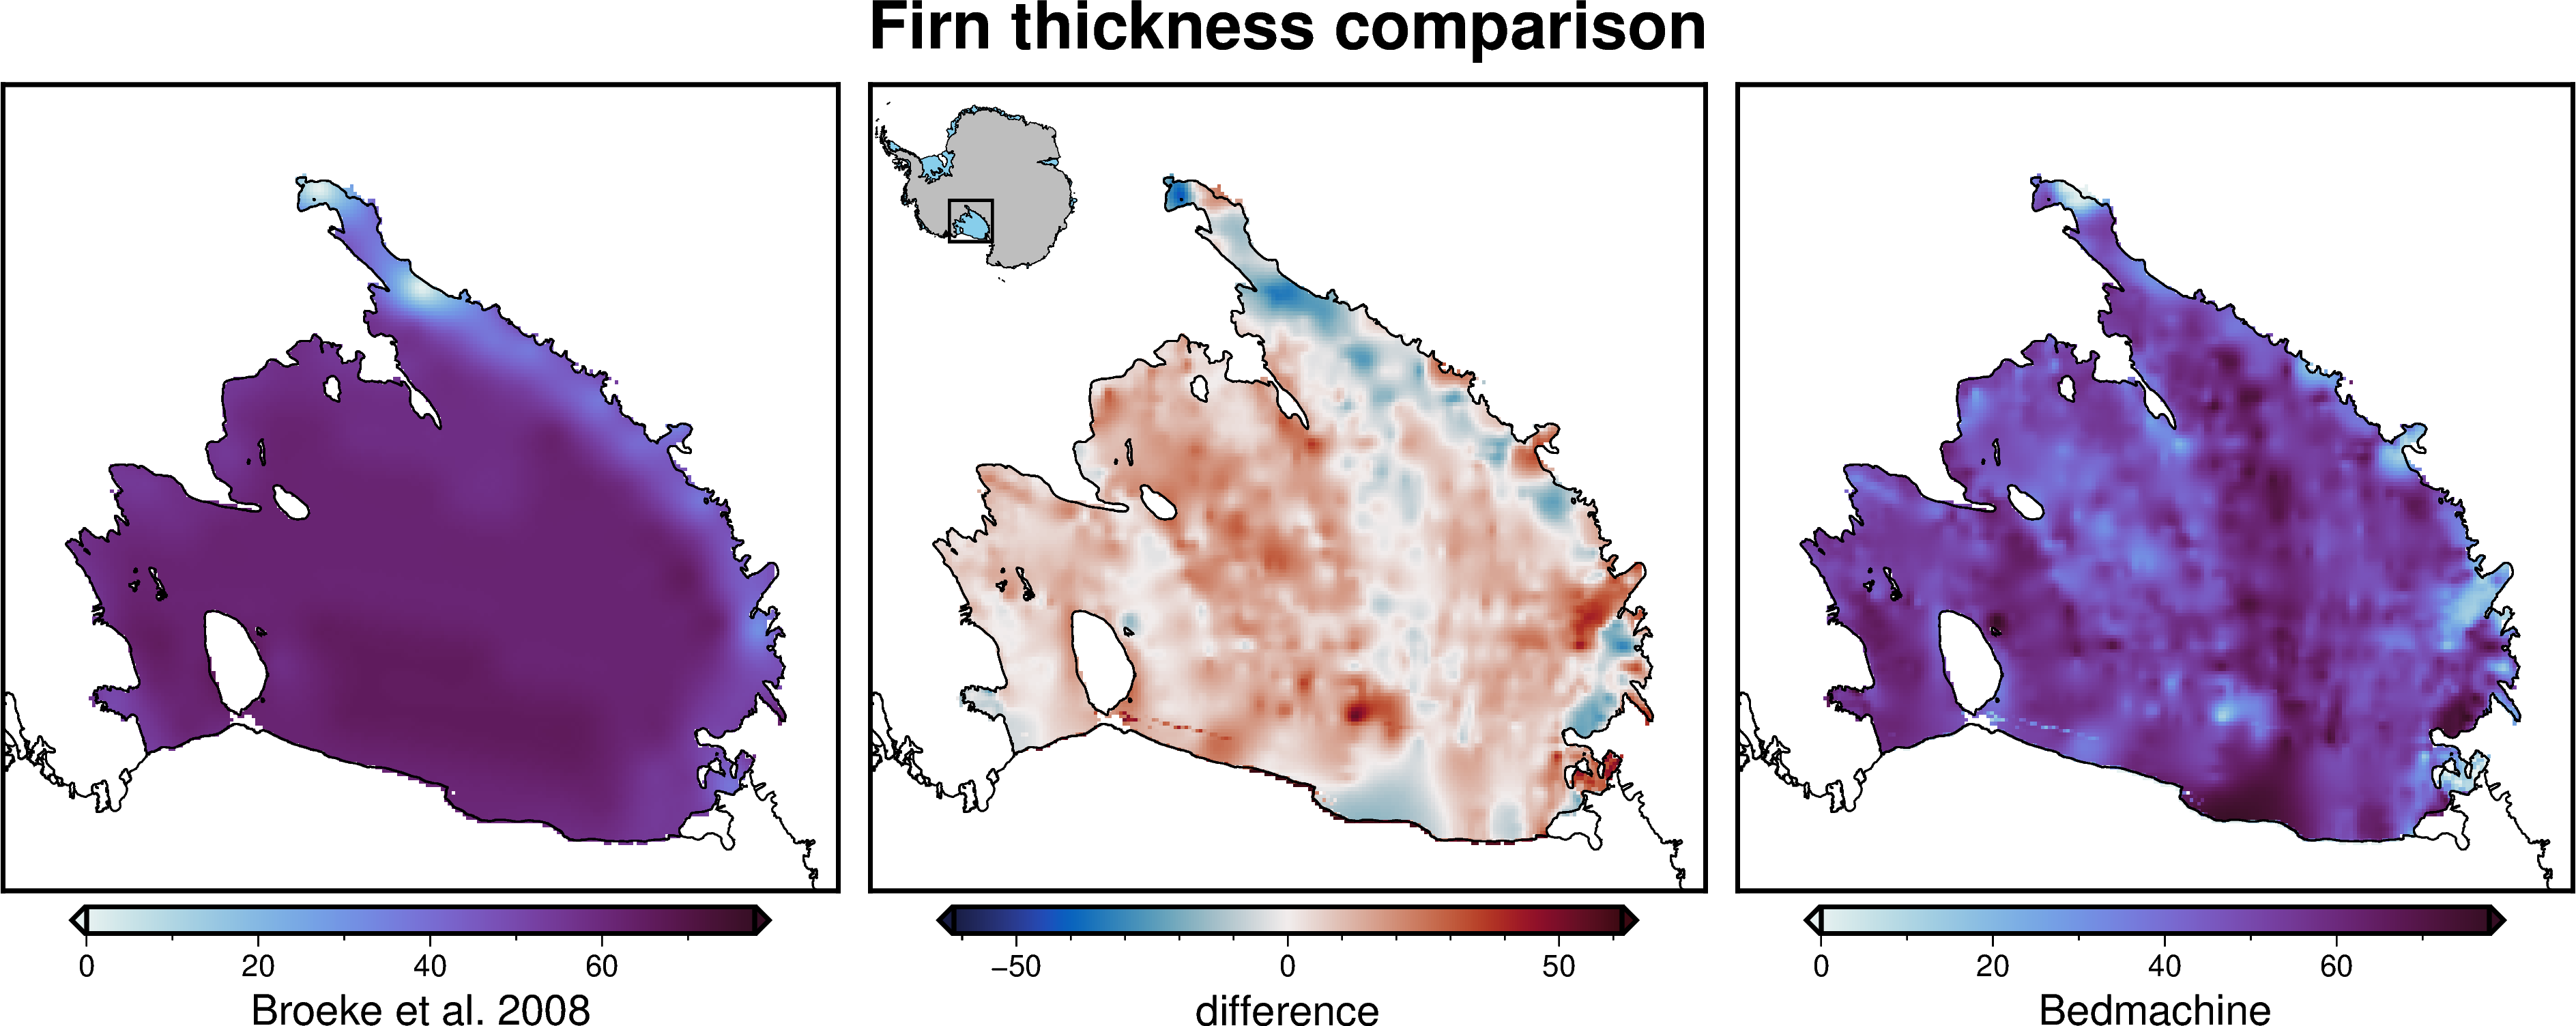

In [21]:
grids = utils.grd_compare(
    broeke_firn_thickness * mask,
    bedmachine_firn_thickness * mask,
    plot=True,
    grid1_name="Broeke et al. 2008",
    grid2_name="Bedmachine",
    title="Firn thickness comparison",
    cmap="dense",
)